In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import agama
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from matplotlib import patches

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = '/Users/adam/Documents/ucl/resonances/figs/'

In [3]:
'''Import DR3 data'''

hdu2 = fits.open('/Users/adam/Documents/ucl/resonances/data/rvs_data_feh2_parsn3.fits', memmap=True)
t2 = Table.read(hdu2)


print(min(t2['PARSN']))
# print(hdu2[1].data)

3.0000005


In [138]:
hdu_RGB = fits.open('/Users/adam/Documents/ucl/resonances/data/table_2_catwise.fits', memmap=True)
t_RGB = Table.read(hdu_RGB)

  source_id            l                  b                  ra               dec              parallax      parallax_error         pmra         pmra_error        pmdec        pmdec_error        ruwe          radial_velocity   radial_velocity_error  phot_g_mean_mag    phot_bp_mean_mag   phot_rp_mean_mag     catwise_w1    catwise_w2 mh_xgboost teff_xgboost logg_xgboost in_training_sample
-------------- ------------------ ------------------ ----------------- ------------------ ------------------ -------------- ------------------- ----------- ------------------- ----------- ------------------ ------------------- --------------------- ------------------ ------------------ ----------------- ----------------- ---------- ---------- ------------ ------------ ------------------
15741055975040 176.73918412075122 -48.57203534129479 45.13603797419482 0.3350430956016859 1.4397923255548803    0.018947227 -0.7112795435300391 0.017718347 -1.4120979387124977 0.016528113 1.0360406999999998 -0.7388944000

In [4]:
'''Transform and cut data'''

coords = coord.SkyCoord(ra=t2['RA']*u.deg, dec=t2['DEC']*u.deg, distance=t2['DIST']*u.kpc, pm_ra_cosdec=t2['PMRA']*u.mas/u.yr, pm_dec=t2['PMDEC']*u.mas/u.yr, radial_velocity=t2['VLOS']*u.km/u.s)

galcen_v_sun = np.array([11.1, 247.4, 7.25])*u.km/u.s#(12.9, 245.6, 7.78)

R_sun = 8.178

coords = coords.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic = np.array([coords.x.value, coords.y.value, coords.z.value, coords.v_x.value, coords.v_y.value, coords.v_z.value]).T

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic = ic*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn = t2['PARSN']
dist = t2['DIST']
MH = t2['MH']
logg = t2['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn > parsn_min) * (dist < dist_max)

ic = ic[cut]
MH = MH[cut]
logg = logg[cut]
dist = dist[cut]
# parsn = parsn[parsn > parsn_min]



In [5]:
'''Remove large variables'''
del hdu2, t2, coords, parsn, cut


In [6]:
'''Calculate data quantities'''

# bar_angle = 30 * np.pi/180

# phi_data = (np.arctan2(ic[:,1], ic[:,0]) - bar_angle + np.pi) % (2 * np.pi) - np.pi

# plt.hist(phi_data*180/np.pi, bins=100)
# plt.show()
# plt.close()

# r_data = np.linalg.norm(ic[:,0:3], axis=1)
R_data = np.linalg.norm(ic[:,0:2], axis=1)
phi_data_sun = np.arctan2(ic[:,1], ic[:,0])
z_data = ic[:,2]

R_hat = ic[:,0:3] * [1, 1, 0] / R_data[:,None]
vR_data = (ic[:,3:6] * R_hat).sum(axis=1)
phi_hat = np.cross([0,0,1], R_hat)
vphi_data = (ic[:,3:6] * phi_hat).sum(axis=1)
# vz_data = ic[:,5]

# r_hat = ic[:,0:3] / r_data[:,None]
# vr_data = (ic[:,3:6] * r_hat).sum(axis=1)

# Remove large variables
del R_hat, phi_hat

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/numpy/lib/histograms.py:1066: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


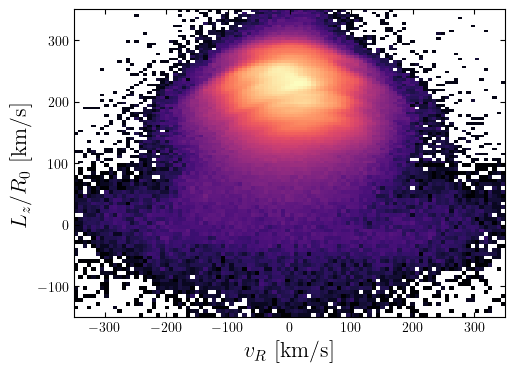

In [7]:
'''Plot velocity space in the disc'''

cut = (abs(R_data - R_sun) < 0.5)*(abs(phi_data_sun) < np.pi/12)*(abs(z_data) < 1)#*(logg < 3)

vR_bins = np.linspace(-350, 350, 101)
vphi_bins = np.concatenate((np.linspace(-150, 100, 41), np.linspace(100, 350, 61)))

fig, ax = plt.subplots(figsize=(6,4))

ax.hist2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=(vR_bins, vphi_bins), norm=mcolors.LogNorm(), density=True, cmap='magma')

ax.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)
ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

ax.set_aspect('equal')

In [151]:

'''Choose potential'''
agama_pot_path = '/Users/adam/Documents/ucl/resonances/agama_potentials/'#'/data/amd206/test/envs/py38_2/lib/python3.8/site-packages/agama/data/'
# pot = agama.Potential(agama_pot_path+'McMillan17.ini')
pot_axi = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')

In [9]:
'''Calculate energy and angular momentum'''

# Calculate energy
E_data = 0.5 * (ic[:,3:6]**2).sum(axis=1) + pot_axi.potential(ic[:,0:3])

# Calculate angular momentum
Lz_data = np.cross(ic[:,0:3], ic[:,3:6], axis=1)[:,2]

# z-component
# L_z_data = L_data[:,2]

af = agama.ActionFinder(pot_axi)
act_data = af(ic)

# # res_ratio = (freq_data[:,2] - Omega_b)/freq_data[:,0]
ecc_data = (1 - (1 + act_data[:,0]/act_data[:,2])**(-2))**0.5

# J_tot = abs(act_data).sum(axis=1)
# eta_data = act_data[:,2]/J_tot
# zeta_data = (act_data[:,1] - act_data[:,0])/J_tot

/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_80947/2512517158.py:16: RuntimeWarning: invalid value encountered in sqrt
  ecc_data = (1 - (1 + act_data[:,0]/act_data[:,2])**(-2))**0.5


In [10]:
'''Load simulation'''

# Load pre-run simulation
o = np.load('/Users/adam/Documents/ucl/resonances/sims/trajs_Hunter.npy', allow_pickle=True)

(array([[0., 2., 2., ..., 1., 2., 0.],
        [3., 2., 0., ..., 1., 1., 0.],
        [2., 1., 4., ..., 0., 0., 2.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 5.  ,  5.07,  5.14,  5.21,  5.28,  5.35,  5.42,  5.49,  5.56,
         5.63,  5.7 ,  5.77,  5.84,  5.91,  5.98,  6.05,  6.12,  6.19,
         6.26,  6.33,  6.4 ,  6.47,  6.54,  6.61,  6.68,  6.75,  6.82,
         6.89,  6.96,  7.03,  7.1 ,  7.17,  7.24,  7.31,  7.38,  7.45,
         7.52,  7.59,  7.66,  7.73,  7.8 ,  7.87,  7.94,  8.01,  8.08,
         8.15,  8.22,  8.29,  8.36,  8.43,  8.5 ,  8.57,  8.64,  8.71,
         8.78,  8.85,  8.92,  8.99,  9.06,  9.13,  9.2 ,  9.27,  9.34,
         9.41,  9.48,  9.55,  9.62,  9.69,  9.76,  9.83,  9.9 ,  9.97,
        10.04, 10.11, 10.18, 10.25, 10.32, 10.39, 10.46, 10.53, 10.6 ,
        10.67, 10.74, 10.81, 10.88, 10.95, 11.02, 11.09, 11.16, 11.23,
        11.3 , 11.37, 11.44, 11.51, 11.58

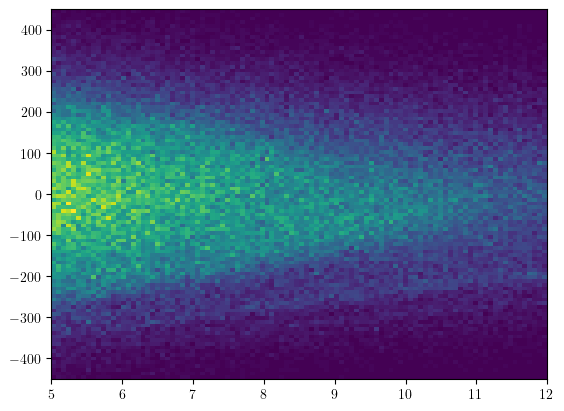

In [11]:
'''Calculate simulation quantities'''
from scipy.integrate import quad

# Functions to calculate pattern speed and bar angle
def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b


# Simulation parameters (CAREFUL THAT THEY MATCH THE SIMULATION SETUP)
# Potential parameters
R_sun_sim = 8.178
vcirc_sun_sim = 229 #236.9

# Bar parameters
t0 = 0  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 60
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# Calculate simulation coordinates
ts = o[:,0][0]
trajs = np.stack(o[:,1]).transpose((1,0,2))

# Delete original array
del o

Omega_b_sim = np.zeros(len(ts))
phi_b_sim = np.zeros(len(ts))

for i in range(len(ts)):
    Omega_b_sim[i] = calc_Omega_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b_sim[i] = calc_phi_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)

R_sim = np.linalg.norm(trajs[:,:,0:2], axis=-1)
phi_sim = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b_sim[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = trajs[:,:,0:3] * [1, 1, 0] / R_sim[:,:,None]
phi_hat = np.cross([0,0,1], R_hat)
vR_sim = (trajs[:,:,3:6] * R_hat).sum(axis=-1)
vphi_sim = (trajs[:,:,3:6] * phi_hat).sum(axis=-1)

X_sim = R_sim * np.cos(phi_sim)
Y_sim = R_sim * np.sin(phi_sim)
Z_sim = trajs[:,:,2]

phi_sun = -np.pi/6
X_sun = R_sun * np.cos(phi_sun)
Y_sun = R_sun * np.sin(phi_sun)

dist_sim = ((X_sim - X_sun)**2 + (Y_sim - Y_sun)**2 + Z_sim**2)**0.5

Lz_sim = np.cross(trajs[:,:,0:3], trajs[:,:,3:6])[:,:,2]

snap = -1

phi_range = np.pi/12
cut = (Lz_sim[snap] > 0)*(abs(Lz_sim[snap]) < 500)*(abs(phi_sim[snap]%np.pi - 5/6*np.pi) < phi_range)

R_bins = np.linspace(5, 12, 101)
vR_bins = np.linspace(-450, 450, 101)

plt.hist2d(R_sim[snap,cut], vR_sim[snap,cut], bins=(R_bins, vR_bins))

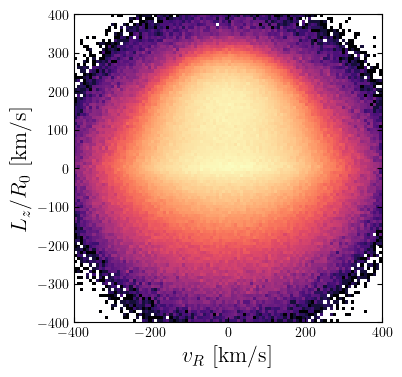

In [13]:
'''Initial velocity distribution of simulation'''

R_range = 1
z_max = 2

cut = (abs(R_sim[0] - R_sun) < R_range)*(trajs[snap,:,2] < z_max)

bins = np.linspace(-400, 400, 101)

fig, ax = plt.subplots(figsize=(4,4))


hist, _, _ = np.histogram2d(vR_sim[0,cut], vphi_sim[0,cut]*R_sim[0,cut]/R_sun, bins=bins)
ax.imshow(hist.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='magma')

ax.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

ax.set_aspect('equal')
ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

plt.savefig(figpath+'sim_initial.pdf', dpi=200, bbox_inches='tight')


In [139]:
hdu_RGB = fits.open('/Users/adam/Documents/ucl/resonances/data/table_2_catwise.fits', memmap=True)
t_RGB = Table.read(hdu_RGB)

print(t_RGB[0])

  source_id            l                  b                  ra               dec              parallax      parallax_error         pmra         pmra_error        pmdec        pmdec_error        ruwe          radial_velocity   radial_velocity_error  phot_g_mean_mag    phot_bp_mean_mag   phot_rp_mean_mag     catwise_w1    catwise_w2 mh_xgboost teff_xgboost logg_xgboost in_training_sample
-------------- ------------------ ------------------ ----------------- ------------------ ------------------ -------------- ------------------- ----------- ------------------- ----------- ------------------ ------------------- --------------------- ------------------ ------------------ ----------------- ----------------- ---------- ---------- ------------ ------------ ------------------
15741055975040 176.73918412075122 -48.57203534129479 45.13603797419482 0.3350430956016859 1.4397923255548803    0.018947227 -0.7112795435300391 0.017718347 -1.4120979387124977 0.016528113 1.0360406999999998 -0.7388944000

In [144]:
'''Transform and cut RGB sample data'''

coords_RGB = coord.SkyCoord(ra=t_RGB['ra']*u.deg, dec=t_RGB['dec']*u.deg, distance=1/t_RGB['parallax']*u.kpc, pm_ra_cosdec=t_RGB['pmra']*u.mas/u.yr, pm_dec=t_RGB['pmdec']*u.mas/u.yr, radial_velocity=t_RGB['radial_velocity']*u.km/u.s)

coords_RGB = coords_RGB.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic_RGB = np.array([coords_RGB.x.value, coords_RGB.y.value, coords_RGB.z.value, coords_RGB.v_x.value, coords_RGB.v_y.value, coords_RGB.v_z.value]).T

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic_RGB = ic_RGB*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn_RGB = t_RGB['parallax']/t_RGB['parallax_error']
dist_RGB = 1/t_RGB['parallax']
MH_RGB = t_RGB['mh_xgboost']
# logg = t_RGB['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn_RGB > parsn_min) * (dist_RGB < dist_max)

ic_RGB = ic_RGB[cut]
MH_RGB = MH_RGB[cut]

R_RGB = np.linalg.norm(ic_RGB[:,0:2], axis=1)
phi_RGB_sun = np.arctan2(ic_RGB[:,1], ic_RGB[:,0])
z_RGB = ic_RGB[:,2]

R_hat = ic_RGB[:,0:3] * [1, 1, 0] / R_RGB[:,None]
vR_RGB = (ic_RGB[:,3:6] * R_hat).sum(axis=1)
phi_hat = np.cross([0,0,1], R_hat)
vphi_RGB = (ic_RGB[:,3:6] * phi_hat).sum(axis=1)


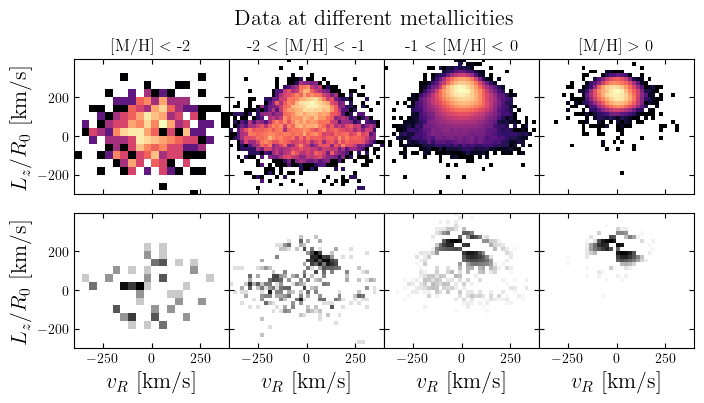

In [150]:
'''Plot RGB in different metallicity/position bins'''

# Select radial, azimuthal and metallicity ranges in which to plot
R_range = 1
phi_range = np.pi/12
z_max = 2
MH_max = 100

MH_bins = np.array([-100, -2, -1, 0, 100])
R_bins = np.linspace(5, 12, 8)

fig, axs = plt.subplots(2, len(MH_bins)-1, figsize=(8,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0., hspace=0.)


for i in range(len(MH_bins)-1):
# for i in range(len(R_bins)-1):
    
    if i==0:
        bins = np.linspace(-400, 400, 21)
    
    else:
        bins = np.linspace(-400, 400, 41) 
    
    cut = (MH_RGB > MH_bins[i])*(MH_RGB < MH_bins[i+1])*(abs(R_RGB - R_sun) < R_range)*(abs(phi_RGB_sun) < phi_range)*(abs(z_RGB) < z_max)#*(eta_RGB<0.99)
    # cut = (MH < -1)*(abs(phi_RGB_sun)<np.pi/24)*(R_RGB > R_bins[i])*(R_RGB < R_bins[i+1])

    hist, _, _ = np.histogram2d(vR_RGB[cut], vphi_RGB[cut]*R_RGB[cut]/R_sun, bins=bins)
    
    axs[0,i].imshow(hist.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='nearest', origin='lower', norm=mcolors.LogNorm(), cmap='magma')
    
    hist_antisym = (hist - np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
    
    axs[1,i].imshow(hist_antisym.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='nearest', origin='lower', norm=mcolors.LogNorm(), cmap='Greys')
    # axs[1,i].imshow(hist_antisym.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='none', origin='lower', norm=mcolors.LogNorm(vmax=100), cmap='Greys')
    
    # axs[i].hist2d(vr_RGB[cut], vphi_RGB[cut], bins=bins, norm=mcolors.LogNorm())
    axs[1,i].set_xlabel('$v_R$ [km/s]', fontsize=16)

    if i==0:
        axs[0,i].set_title('[M/H] $<$ '+str(MH_bins[i+1]))
    
    elif i==len(MH_bins)-2:
        axs[0,i].set_title('[M/H] $>$ '+str(MH_bins[i]))

    else:
        axs[0,i].set_title(str(MH_bins[i])+' $<$ [M/H] $<$ '+str(MH_bins[i+1]))


for ax in axs[:,0].flat:
    ax.set_ylim(-299, 399)
    ax.set_aspect('equal')
    ax.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

for ax in axs.flat:
    ax.set_xlim(-399, 399)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

plt.suptitle('Data at different metallicities', fontsize=16)

plt.savefig(figpath+'data_metallicity.pdf', dpi=200, bbox_inches='tight')

plt.show()
plt.close()


Omega_b =  32.50270916353844


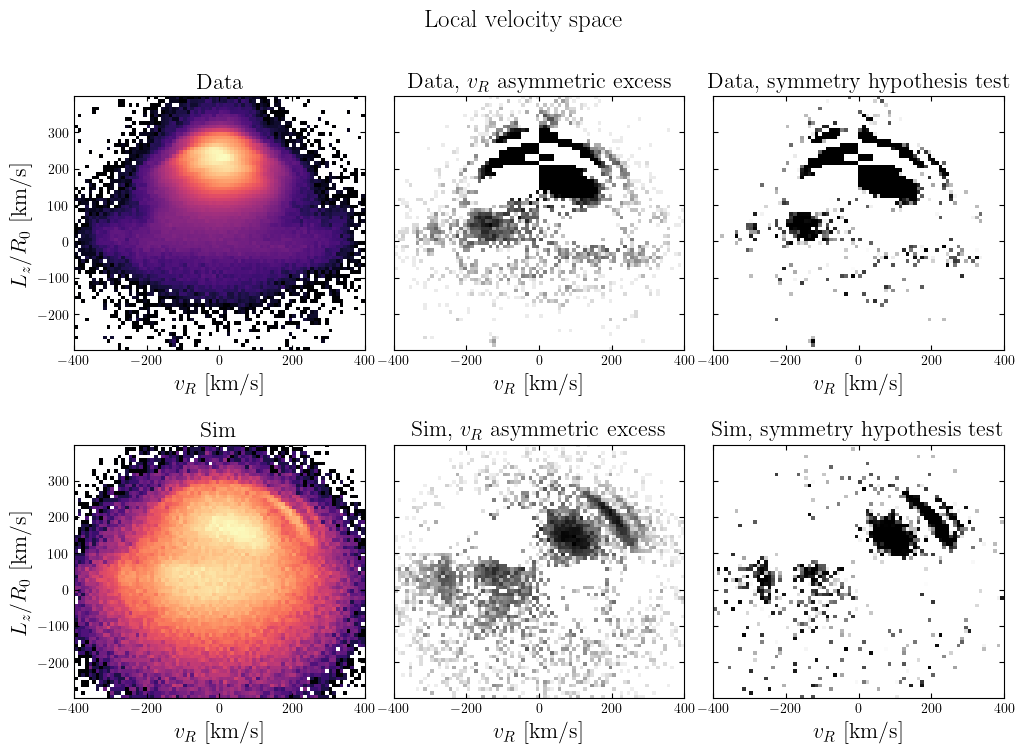

In [76]:

'''Plot antisymmetric distribution'''

from scipy.ndimage import gaussian_filter, maximum_filter
from skimage.feature import peak_local_max
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import binomtest

fig, axs = plt.subplots(2,3, figsize=(12,8), sharex='row', sharey='row')#, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Select radial, azimuthal and metallicity ranges in which to plot
R_range = 1
phi_range = np.pi/12
z_max = 2
MH_max = 100

# Choose simulation snapshot
snap = -2
print('Omega_b = ', Omega_b_sim[snap])

# Data
# cut_all = (abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)#(dist<dist_limit_all)#*(eta_data<0.98)#*(logg<3)
cut = (MH < MH_max)*(abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)#(dist<dist_limit)

bins = np.linspace(-400, 400, 81)

# hist_all, _, _ = np.histogram2d(vR_data[cut_all], vphi_data[cut_all], bins=bins)
hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=bins)
hist_sym = hist + np.flip(hist, axis=0)
hist_antisym = hist - np.flip(hist, axis=0)
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[0,0].imshow(hist_all.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[0,0].imshow(hist.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='magma')
axs[0,1].imshow(hist_antisym.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(vmax=100), cmap='Greys')

# Hypothesis test for symmetry
pvalue_array = np.zeros(hist.shape)

for i in range(pvalue_array.shape[0]):
    for j in range(pvalue_array.shape[1]):
        n = int(hist_sym[i,j])
        k = int(hist[i,j])
        if n>1:
            pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

axs[0,2].imshow(pvalue_array.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', vmin=0.9, vmax=1, cmap='Greys')

# Simulation
# cut_0 = (abs(R_sim[0] - R_sun) < R_range)*(abs(phi_sim[0]%np.pi - 5/6*np.pi) < phi_range)
cut = (abs(R_sim[snap] - R_sun) < R_range)*(abs(phi_sim[snap]%np.pi - 5/6*np.pi) < phi_range)*(trajs[snap,:,2] < z_max)

bins = np.linspace(-400, 400, 81)

# hist_0, _, _ = np.histogram2d(vR_sim[0,cut_0], vphi_sim[0,cut_0], bins=bins)
hist, _, _ = np.histogram2d(vR_sim[snap,cut], vphi_sim[snap,cut]*R_sim[snap,cut]/R_sun, bins=bins)
hist_sym = hist + np.flip(hist, axis=0)
hist_antisym = hist - np.flip(hist, axis=0)
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[1,0].imshow(hist_0.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[1,0].imshow(hist.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='magma')
axs[1,1].imshow(hist_antisym.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', norm=mcolors.LogNorm(), cmap='Greys')

# Hypothesis test for symmetry
pvalue_array = np.zeros(hist.shape)

for i in range(pvalue_array.shape[0]):
    for j in range(pvalue_array.shape[1]):
        n = int(hist_sym[i,j])
        k = int(hist[i,j])
        if n>1:
            pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

axs[1,2].imshow(pvalue_array.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='nearest', vmin=0.9, vmax=1, cmap='Greys')

for ax in axs[:,0].flat:
    ax.set_ylim(-299, 399)
    ax.set_aspect('equal')
    ax.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

for ax in axs.flat:
    # ax.set_xlim(-399, 399)
    ax.set_xlabel('$v_R$ [km/s]', fontsize=16)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


# axs[0,0].set_title('Data', fontsize=16)
axs[0,0].set_title('Data', fontsize=16)
axs[0,1].set_title('Data, $v_R$ asymmetric excess', fontsize=16)
axs[0,2].set_title('Data, symmetry hypothesis test', fontsize=16)

# axs[1,0].set_title('Simulation, initial', fontsize=16)
axs[1,0].set_title('Sim', fontsize=16)
axs[1,1].set_title('Sim, $v_R$ asymmetric excess', fontsize=16)
axs[1,2].set_title('Sim, symmetry hypothesis test', fontsize=16)


fig.suptitle('Local velocity space', fontsize=18, y=0.98)

# axs[0].set_title('$[M/H]<-1$, distance $<1$ kpc', fontsize=16)
# axs[1].set_title('$v_R$ asymmetric excess', fontsize=16)
# plt.xlim(-350, -200)
# plt.ylim(-100, 100)

plt.savefig(figpath+'data_sim.pdf', dpi=200, bbox_inches='tight')

plt.show()

del hist, hist_antisym, cut

<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_80947/3965066980.py:46: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$f_\mathrm{trapped,min}$', fontsize=16)


Omega_b =  32.50270916353844


Text(0.5, 0, '$L_z/R_0$ [km/s]')

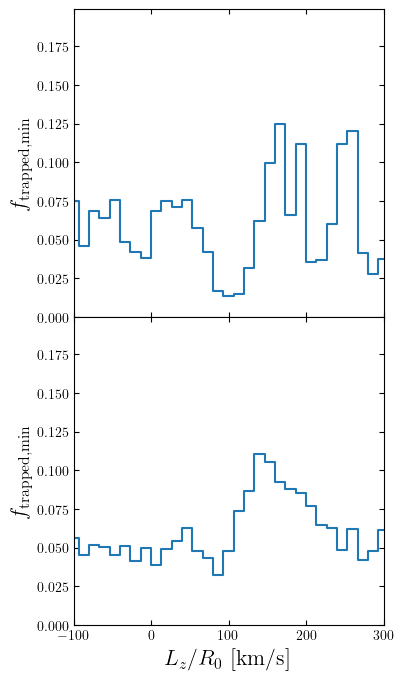

In [48]:
'''Calculate lower bound for fraction of trapped stars as a function of Lz'''

from scipy.ndimage import gaussian_filter

fig, axs = plt.subplots(2, figsize=(4,8), sharex=True, sharey=True)#, sharey=True)
plt.subplots_adjust(hspace=0)

# Select radial, azimuthal and metallicity ranges in which to plot
R_range = 1
phi_range = np.pi/12
z_max = 2
MH_max = 100

# Choose simulation snapshot
snap = -2
print('Omega_b = ', Omega_b_sim[snap])

# Data
# cut_all = (abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)#(dist<dist_limit_all)#*(eta_data<0.98)#*(logg<3)
cut = (MH < MH_max)*(abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)#(dist<dist_limit)

bins = np.linspace(-400, 400, 61)

hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=bins)
hist_antisym = hist - np.flip(hist, axis=0)

frac_bound = 0.25*abs(hist_antisym).sum(axis=0) / hist.sum(axis=0)

axs[0].step(bins[1:], frac_bound)




cut = (abs(R_sim[snap] - R_sun) < R_range)*(abs(phi_sim[snap]%np.pi - 5/6*np.pi) < phi_range)*(abs(trajs[snap,:,2]) < z_max)

hist, _, _ = np.histogram2d(vR_sim[snap,cut], vphi_sim[snap,cut]*R_sim[snap,cut]/R_sun, bins=bins)
hist_antisym = hist - np.flip(hist, axis=0)

frac_bound = 0.25*abs(hist_antisym).sum(axis=0) / hist.sum(axis=0)

axs[1].step(bins[1:], frac_bound)

for ax in axs.flat:
    ax.set_xlim(-100, 300)
    ax.set_ylim(0, 0.199)
    ax.set_ylabel('$f_\mathrm{trapped,min}$', fontsize=16)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

axs[-1].set_xlabel('$L_z/R_0$ [km/s]', fontsize=16)

In [21]:
'''Function to calculate radial phase space track of resonant orbit'''

from scipy.interpolate import CubicSpline

def calc_res_orbit(pot, Omega_b, res_ratio, Lz, E_offset=0):
    # Create ActionFinder to compute frequencies
    # af = agama.ActionFinder(pot)

    # Make grid of initial conditions at Sun's radius
    N_grid = 41
    vR_grid = np.linspace(1, 400, N_grid)
    ic = np.array([R_sun*np.ones(N_grid), np.zeros(N_grid), np.zeros(N_grid), vR_grid, Lz/R_sun*np.ones(N_grid), 1e-1*np.ones(N_grid)]).T

    o = agama.orbit(ic=ic, potential=pot, Omega=Omega_b, time=1, trajsize=1001, verbose=False)
    ts = o[:,0][0]
    orbits = np.stack(o[:,1]).transpose((1,0,2))
    
    R_orbits = np.linalg.norm(orbits[:,:,0:2], axis=-1)
    R_hat = orbits[:,:,0:3] * [1, 1, 0] / R_orbits[:,:,None]
    vR_orbits = (orbits[:,:,3:6] * R_hat).sum(axis=-1)
    
    
    phi_orbits = np.arctan2(orbits[:,:,1], orbits[:,:,0]) + Omega_b * ts[:,None]

    

    phi_orbits_unwrap = np.unwrap(phi_orbits, axis=0)

    apo_indices = np.where((vR_orbits[:-1] > 0)*(vR_orbits[1:] < 0))

    # Calculate radial periods and frequencies
    T_R = np.full(vR_orbits.shape[1], np.nan)
    Omega_phi = np.full(vR_orbits.shape[1], np.nan)

    

    for m in range(vR_orbits.shape[1]):
        column_true_indices = apo_indices[0][apo_indices[1] == m]  # Get the indices of True values in column m
        if len(column_true_indices) >= 2:
            T_R[m] = (column_true_indices[1] - column_true_indices[0]) * (ts[1] - ts[0])
            Omega_phi[m] = (phi_orbits_unwrap[column_true_indices[1],m] - phi_orbits_unwrap[column_true_indices[0],m]) / (ts[column_true_indices[1]] - ts[column_true_indices[0]])


    

    # print('Loop time =', end_time-start_time)
    
    Omega_R = 2*np.pi / T_R

    freq_ratio = -(Omega_phi - Omega_b)/Omega_R

    vR_grid_fine = np.linspace(vR_grid[0], vR_grid[-1], 1001)
    freq_ratio_inter = np.interp(vR_grid_fine, vR_grid, freq_ratio)


    # act, ang, freq = af(ic, angles=True)

    # freq_ratio = -(freq[:,2] - Omega_b)/freq[:,0]

    vR_func_list = []

    res_dist = abs(freq_ratio_inter - res_ratio)

    res_index = np.nanargmin(res_dist)
    res_ic = ic[0]

    res_ic[3] = (vR_grid_fine[res_index]**2 + 2*E_offset)**0.5

    res_orbit = agama.orbit(ic=res_ic, potential=pot, Omega=Omega_b, time=1, trajsize=1001)[1]

    R_orbit = np.linalg.norm(res_orbit[:,0:2], axis=-1)
    R_hat = res_orbit[:,0:3] * [1, 1, 0] / R_orbit[:,None]
    vR_orbit = (res_orbit[:,3:6] * R_hat).sum(axis=-1)

    # try:
    first_apo_index = np.where((vR_orbit[:-1] > 0)*(vR_orbit[1:] < 0))[0][0]
    first_peri_index = np.where((vR_orbit[:-1] < 0)*(vR_orbit[1:] > 0))[0][0]

    R_orbit_cut = R_orbit[first_apo_index+1:first_peri_index-1]
    vR_orbit_cut = vR_orbit[first_apo_index+1:first_peri_index-1]

    vR_func = CubicSpline(np.flip(R_orbit_cut), np.flip(-abs(vR_orbit_cut)), extrapolate=False)

    return vR_func

Omega_b =  32.50270916353844


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_80947/4116575497.py:24: RuntimeWarning: invalid value encountered in divide
  hist_colnorm = hist / hist.sum(axis=1)[:,None]


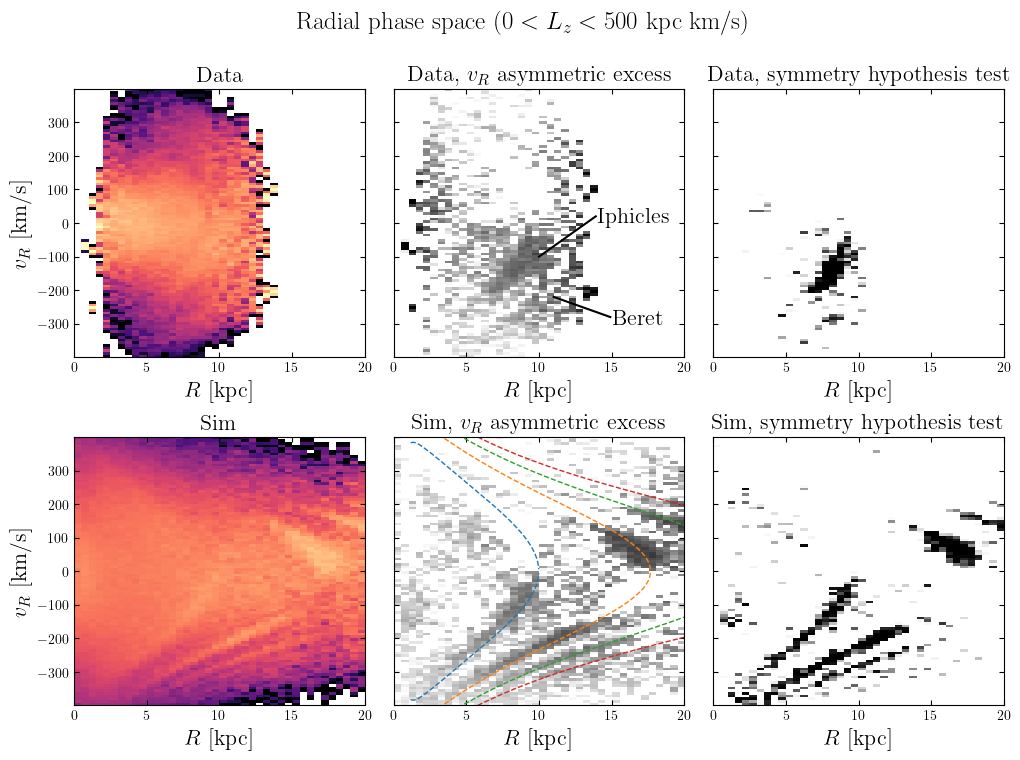

In [80]:
'''Plot radial phase space'''

fig, axs = plt.subplots(2,3, figsize=(12,8), sharex='row', sharey='row')#, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Select Lz, azimuthal and metallicity ranges in which to plot
Lz_max = 500
phi_range = np.pi/12
z_max = 2
MH_max = 100

# Choose simulation snapshot
snap = -2
print('Omega_b = ', Omega_b_sim[snap])

# Data
cut = (Lz_data > 0)*(Lz_data < Lz_max)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)#(dist<dist_limit_all)#*(eta_data<0.98)#*(logg<3)

R_bins = np.linspace(0, 20, 41)
vR_bins = np.linspace(-400, 400, 101)

hist, _, _ = np.histogram2d(R_data[cut], vR_data[cut], bins=(R_bins, vR_bins))
hist = gaussian_filter(hist, (0,0.5))
hist_colnorm = hist / hist.sum(axis=1)[:,None]
hist_colnorm[np.isnan(hist_colnorm)] = 0
hist_sym = hist + np.flip(hist, axis=1)
hist_antisym = hist_colnorm - np.flip(hist_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, 1)


# axs[0,0].imshow(hist_all.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[0,0].imshow(hist_colnorm.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[0,1].imshow(hist_antisym.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# Hypothesis test for symmetry
pvalue_array = np.zeros(hist.shape)

for i in range(pvalue_array.shape[0]):
    for j in range(pvalue_array.shape[1]):
        n = int(hist_sym[i,j])
        k = int(hist[i,j])
        if n>1:
            pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

axs[0,2].imshow(pvalue_array.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

# Simulation
cut = (Lz_sim[snap] > 0)*(Lz_sim[snap] < Lz_max)*(abs(phi_sim[snap]%np.pi - 5/6*np.pi) < phi_range)*(abs(trajs[snap,:,2]) < z_max)

hist, _, _ = np.histogram2d(R_sim[snap,cut], vR_sim[snap,cut], bins=(R_bins, vR_bins))
hist = gaussian_filter(hist, (0,0.5))
hist_colnorm = hist / hist.sum(axis=1)[:,None]
hist_sym = hist + np.flip(hist, axis=1)
hist_antisym = hist_colnorm - np.flip(hist_colnorm, axis=1)
# hist_antisym = gaussian_filter(hist_antisym, (0,0.5))
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# axs[1,0].imshow(hist_0.T, extent=(bins[0], bins[-1], bins[0], bins[-1]), origin='lower', interpolation='none', norm=mcolors.LogNorm(), cmap='viridis')
axs[1,0].imshow(hist_colnorm.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='magma')
axs[1,1].imshow(hist_antisym.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', norm=mcolors.LogNorm(vmin=0.0001, vmax=0.1), cmap='Greys')

# Hypothesis test for symmetry
pvalue_array = np.zeros(hist.shape)

for i in range(pvalue_array.shape[0]):
    for j in range(pvalue_array.shape[1]):
        n = int(hist_sym[i,j])
        k = int(hist[i,j])
        if n>1:
            pvalue_array[i,j] = 1 - binomtest(k, n, p=0.5, alternative='greater').pvalue

axs[1,2].imshow(pvalue_array.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), origin='lower', interpolation='nearest', aspect='auto', vmin=0.9, vmax=1, cmap='Greys')

res_ratio_list = [0, 0.5, 1, 1.5]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
R_grid = np.linspace(0, 20, 10001)
for j in range(len(res_ratio_list)):
    vR_res = calc_res_orbit(pot_axi, Omega_b_sim[snap], res_ratio_list[j], 250)
    axs[1,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
    axs[1,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)

    # axs[0,1].plot(R_grid, vR_res(R_grid), ls='--', c=colors[j], lw=1)
    # axs[0,1].plot(R_grid, -vR_res(R_grid), ls='--', c=colors[j], lw=1)


for ax in axs[:,0].flat:
    ax.set_ylim(-399, 399)
    # ax.set_aspect('equal')
    ax.set_ylabel('$v_R$ [km/s]', fontsize=16)

for ax in axs.flat:
    ax.set_xlim(0, 20)
    ax.set_xlabel('$R$ [kpc]', fontsize=16)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


axs[0,1].text(14, 0, 'Iphicles', fontsize=16)
axs[0,1].text(15, -300, 'Beret', fontsize=16)

axs[0,1].plot([10,13.9], [-100, 20], c='k')
axs[0,1].plot([11,14.9], [-220, -280], c='k')

# axs[0,0].set_title('Data', fontsize=16)
axs[0,0].set_title('Data', fontsize=16)
axs[0,1].set_title('Data, $v_R$ asymmetric excess', fontsize=16)
axs[0,2].set_title('Data, symmetry hypothesis test', fontsize=16)

# axs[1,0].set_title('Simulation, initial', fontsize=16)
axs[1,0].set_title('Sim', fontsize=16)
axs[1,1].set_title('Sim, $v_R$ asymmetric excess', fontsize=16)
axs[1,2].set_title('Sim, symmetry hypothesis test', fontsize=16)


fig.suptitle('Radial phase space ($0<L_z<500$ kpc km/s)', fontsize=18, y=0.98)

# axs[0].set_title('$[M/H]<-1$, distance $<1$ kpc', fontsize=16)
# axs[1].set_title('$v_R$ asymmetric excess', fontsize=16)
# plt.xlim(-350, -200)
# plt.ylim(-100, 100)

plt.savefig(figpath+'R_vR.pdf', dpi=200, bbox_inches='tight')

plt.show()


In [170]:
from scipy.optimize import fsolve

# Function to calculate NFW scale radius given masses at two radii
def calc_NFW_params(M_inner, M_outer, r_inner=R_sun, r_outer=20):
    def mass_ratio(a_NFW, r_inner, r_outer):
        return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
    
    def mass_ratio_diff(a_NFW, M_inner, M_outer, r_inner, r_outer):
        return mass_ratio(a_NFW, r_inner, r_outer) - M_outer/M_inner
    
    initial_guess = 10

    a_NFW = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer))[0]
    rho_0 = M_inner / (4 * np.pi * a_NFW**3) * (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))**(-1)

    return rho_0, a_NFW

# Function to calculate potential from local circular velocity and NFW scale radius
def make_pot(vcirc_sun, M20, pot_axi_baryon):
    # Circular speed
    vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

    # Calculate model NFW parameters
    Menc_sun_dark = R_sun * vcirc_dark**2 / agama.G
    M20_baryon = pot_axi_baryon.enclosedMass(20)
    M20_dark = M20*1e11 - M20_baryon
    
    rho_0, a_NFW = calc_NFW_params(Menc_sun_dark, M20_dark)

    # Make DM potential
    pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

    # And total potential
    pot_mod = agama.Potential(pot_axi_baryon, pot_dark)

    return pot_mod

In [23]:
'''Calculate fiducial potential'''

# Potential parameters
vcirc_sun = 236.9
M20 = 1.91

agama_pot_path = '/Users/adam/Documents/ucl/agama_potentials/'

pot_Hunter_path = 'MWPotentialHunter24_full.ini'
pot_Hunter_axi_path = 'MWPotentialHunter24_axi.ini'
pot_bar_baryon_path = 'MWPotentialHunter24_baryon_full.ini'
pot_axi_baryon_path = 'MWPotentialHunter24_baryon_axi.ini'
pot_nonaxi_path = 'MWPotentialHunter24_nonaxi.ini'


# Load Hunter potential
pot_Hunter = agama.Potential(file=agama_pot_path+pot_Hunter_path)
# Load axisymmetric Hunter potential
pot_Hunter_axi = agama.Potential(file=agama_pot_path+pot_Hunter_axi_path)
# Load axisymmetric baryonic potential
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)
# Load full baryonic potential
pot_bar_baryon = agama.Potential(file=agama_pot_path+pot_bar_baryon_path)
# And the axisymmetrised, scaled baryonic potential with equal but negative mass
pot_axi_baryon_neg = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-1,1])

# Make axisymmetric potential
pot_axi = pot_Hunter_axi
# pot_axi = make_pot(vcirc_sun, M20, pot_axi_baryon)

# Make barred potential
# Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
pot_bar = pot_Hunter #agama.Potential(pot_axi, pot_bar_baryon, pot_axi_baryon_neg)

# Export barred potential
pot_bar_mod_path = agama_pot_path+'pot_bar_mod.ini'
pot_bar.export(pot_bar_mod_path)


In [24]:
'''Plot potential density'''

rmax=10

gridr  = np.linspace(-rmax, rmax, 101)  # 1d grid
gridxy = np.column_stack((np.repeat(gridr, len(gridr)), np.tile(gridr, len(gridr))))  # 2d grid
Sigma  = pot_bar.projectedDensity(gridxy, gamma=-bar_angle)  # surface density for a stellar component rotated by bar_angle
logSigma = 2.5 * np.log10(Sigma / np.max(Sigma))      # log-scaled to magnitudes per unit square
# thick lines spaced by one magnitude, thin lines lie halfway between thick ones
plt.contour(gridr, gridr, logSigma.reshape(len(gridr), len(gridr)).T,
    levels=np.linspace(-12,0,17), colors='k', zorder=5, linewidths=[2,1], linestyles='solid')

NameError: name 'bar_angle' is not defined

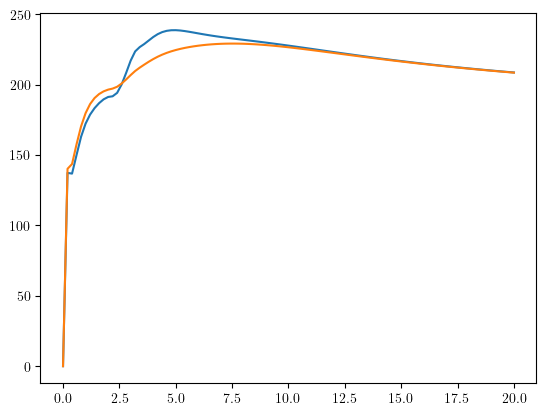

In [22]:
'''Plot rotation curve'''

rgrid = np.linspace(0, 20, 101)

vcirc = (-rgrid * pot_bar.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5

plt.plot(rgrid, vcirc)

vcirc = (-rgrid * pot_axi.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5

plt.plot(rgrid, vcirc)

(-10.0, 10.0)

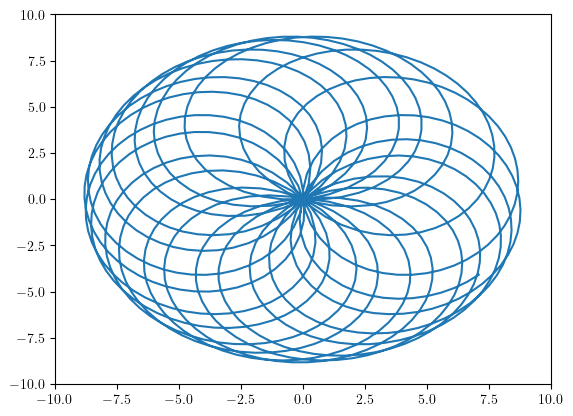

In [135]:
'''Integrate orbits for testing'''

vR = -90
vphi = -2

vX = vR * np.cos(-bar_angle) - vphi * np.sin(-bar_angle)
vY = vR * np.sin(-bar_angle) + vphi * np.cos(-bar_angle)

ic = [R_sun*np.cos(-bar_angle), R_sun*np.sin(-bar_angle), 0, vX, vY, 0]

o = agama.orbit(ic=ic, potential=pot_axi, Omega=35.5, time=2, trajsize=1001)[1]

plt.plot(o[:,0], o[:,1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [25]:
'''Functions to integrate and identify resonant orbits'''

# Function to integrate orbits
def test_part_sim(ic, pot, time, trajsize=2, Omega=0, timestart=0):
    
    o = agama.orbit(ic=ic, potential=pot, Omega=Omega, time=time, trajsize=trajsize, timestart=timestart)
    
    ts = o[:,0][0]
    trajs = np.stack(o[:,1]).transpose((1,0,2))

    return trajs, ts

# Corotation resonance, using phi-phi_b
def find_corot(orbits):
    phi_sim = np.arctan2(orbits[:,:,1], orbits[:,:,0])

    phi_mean = np.mean(phi_sim, axis=0)
    phi_minus_mean = (phi_sim - phi_mean + np.pi)%(2*np.pi) - np.pi

    phi_range_frac = (np.max(phi_minus_mean, axis=0) - np.min(phi_minus_mean, axis=0))/(2*np.pi)

    # Orbits with range of phi less than 90% of 2pi are identified as CR
    corot_flag = phi_range_frac < 0.9

    return corot_flag

# Other resonances, using angle variables
def find_res(orbits, freq, pot_axi, Omega_b, l, m):
    af = agama.ActionFinder(pot_axi)

    # Resonant ratio
    l_over_m = l/m

    # Calculate frequency ratio and distance from chosen resonances
    freq_ratio_approx = (freq[:,2] - Omega_b) / freq[:,0]

    res_dist = abs(freq_ratio_approx + l_over_m)

    res_cut_approx = res_dist < 0.1

    # Now calculate angle variables at all snapshots for the stars near the resonance

    res_flag = np.zeros(len(orbits[0]))
    for i in range(len(res_flag)):
        if res_cut_approx[i] == True:
            # print('yes')
            _, ang,_ = af(orbits[:,i], angles=True)

            # Calculate slow angle
            # theta_s = np.unwrap(m*ang[:,2] + l*ang[:,0])

            # theta_s_mean = np.mean(theta_s)
            # theta_s_minus_mean = (theta_s - theta_s_mean + np.pi)%(2*np.pi) - np.pi

            # theta_s_range_frac = (np.max(theta_s_minus_mean) - np.min(theta_s_minus_mean))/(2*np.pi)

            # plt.plot(theta_s)
            # plt.show()
            # plt.close()

            # print(theta_s_range_frac)


            theta_s = np.unwrap(m*ang[:,2] + l*ang[:,0])#np.unwrap(m*ang[:,2] + l*ang[:,0])

            theta_s_rel = theta_s - theta_s[0]

            theta_s_rel_wrap = (theta_s_rel + np.pi) % (2*np.pi) - np.pi
            try:
                zero_index = np.where((np.sign(theta_s_rel_wrap[:-1])*np.sign(theta_s_rel_wrap[1:]) < 0) * (abs(theta_s_rel_wrap[1:] - theta_s_rel_wrap[:-1]) < np.pi))[0][1]
                theta_s_range = np.max(theta_s[:zero_index]) - np.min(theta_s[:zero_index])
                res_flag[i] = theta_s_range/(2*np.pi) < 0.9

            except:
                try:
                    zero_index = np.where((np.sign(theta_s_rel_wrap[:-1])*np.sign(theta_s_rel_wrap[1:]) < 0) * (abs(theta_s_rel_wrap[1:] - theta_s_rel_wrap[:-1]) < np.pi))[0][0]
                    theta_s_range = np.max(theta_s[:zero_index]) - np.min(theta_s[:zero_index])
                    res_flag[i] = theta_s_range/(2*np.pi) < 0.9

                except:
                    res_flag[i] = True

            # res_flag[i] = theta_s_range_frac < 0.9

            del ang, theta_s#, theta_s_minus_mean
    
    del freq_ratio_approx, res_dist, res_cut_approx

    return res_flag


In [26]:
'''Function to integrate orbits and calculate separatrices'''

def calc_res_flags(res_ratio_list, Omega_b_array, eta_array, pot_axi, vR_grid_flat, vphi_grid_flat, int_time=4, trajsize=501):

    # Array of times
    ts = np.linspace(0, int_time, trajsize)

    res_flag_array = np.zeros((len(res_ratio_list), len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)

    # corot_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # OLR_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # res_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # one_to_one_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # ret_OLR_flag_array = np.zeros((len(Omega_b_array), len(eta_array), len(vR_grid_flat)), dtype=bool)
    # orbits_array = np.zeros((len(Omega_b), trajsize, len(vR_grid_flat), 6))

    # Loop over all pattern speeds (or bar angles, potentials, etc.)
    for i in range(len(Omega_b_array)):
        for j in range(len(eta_array)):

            # Calculate angle of slowing bar
            Omega_b_0 = Omega_b_array[i]
            eta = eta_array[j]

            if eta==0:
                phi_b = Omega_b_0 * ts
            
            else:
                phi_b = 1/eta * np.log(1 + eta*Omega_b_0*ts)

            # result = solve_ivp(calc_Omega_b, t_span=(ts[0], ts[-1]), y0=[0], t_eval=ts, args=(Omega_b_0, eta))
            # ts = result.t
            # phi_b_test = result.y[0]

            # Calculate rotation matrix
            rot_mat = np.zeros((len(ts), 6, 6))
            rot_mat[:,0:3,0:3] = np.array([[np.cos(phi_b), np.sin(phi_b), 0*ts], [-np.sin(phi_b), np.cos(phi_b), 0*ts], [0*ts, 0*ts, np.ones(len(ts))]]).transpose(2,0,1)
            rot_mat[:,3:6,3:6] = np.array([[np.cos(phi_b), np.sin(phi_b), 0*ts], [-np.sin(phi_b), np.cos(phi_b), 0*ts], [0*ts, 0*ts, np.ones(len(ts))]]).transpose(2,0,1)

            # Slowing barred potential

            # If integrating back in time, flip time and bar angle arrays for potential creation
            if int_time<0:
                ts_pot = np.flip(ts)
                phi_b_pot = np.flip(phi_b)
            else:
                ts_pot = np.copy(ts)
                phi_b_pot = np.copy(phi_b)


            # Load full, scaled, rotated baryonic potential
            pot_bar_baryon = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, rotation=np.array([ts_pot, phi_b_pot]).T)
            # And the axisymmetrised, scaled baryonic potential with equal but negative mass
            pot_axi_baryon_neg = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-1,1])

            # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
            # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
            pot_slow = agama.Potential(pot_axi, pot_bar_baryon, pot_axi_baryon_neg)

            # rgrid = np.linspace(0, 20, 101)

            # vcirc = (-rgrid * pot_slow.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5

            # plt.plot(rgrid, vcirc)
            
            # Set up initial conditions given bar angle (Move this out of the loop later?)
            phi_sun = 2*np.pi-bar_angle

            X_sun = R_sun * np.cos(phi_sun)
            Y_sun = R_sun * np.sin(phi_sun)


            vX_grid = vR_grid_flat * np.cos(-bar_angle) - vphi_grid_flat * np.sin(-bar_angle)
            vY_grid = vR_grid_flat * np.sin(-bar_angle) + vphi_grid_flat * np.cos(-bar_angle)

            ic = np.array([X_sun*np.ones(N_grid_R*N_grid_phi), Y_sun*np.ones(N_grid_R*N_grid_phi), np.zeros(N_grid_R*N_grid_phi), vX_grid, vY_grid, np.zeros(N_grid_R*N_grid_phi)+1e-1]).T

            # First calculate frequencies in axisymmetric potential, to identify orbits near resonances
            af = agama.ActionFinder(pot_axi)
            act, ang, freq = af(ic, angles=True)

            # Identify ICs giving orbits near resonances
            # Calculate frequency ratio and distance from nearest resonance
            freq_ratio_approx = (freq[:,2] - Omega_b_0) / freq[:,0]
            nearest_res = np.round(freq_ratio_approx * 2) / 2
            res_dist = abs(freq_ratio_approx - nearest_res)

            # Select only orbits near resonances
            res_cut_approx = res_dist < 0.2
            ic_near_res = ic[res_cut_approx]

            # Steadily rotating bar
            # orbits, ts = test_part_sim(ic, pot_bar, time=int_time, trajsize=trajsize, Omega=Omega_b)

            # Slowing bar
            orbits_near_res, _ = test_part_sim(ic_near_res, pot_slow, time=int_time, trajsize=trajsize)


            orbits = np.zeros((trajsize, len(ic), 6))
            orbits[:,res_cut_approx] = orbits_near_res


            # Rotate coordinates into frame aligned with the bar
            orbits = np.einsum('lij,lmj->lmi', rot_mat, orbits)

            # Identify CR orbits
            for k in range(len(res_ratio_list)):
                res_ratio = res_ratio_list[k]
                res_flag_array[k,i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, res_ratio*2, 2)#find_corot(orbits)
            # corot_flag_array[i,j] = find_corot(orbits)

            # Identify OLR orbits
            # OLR_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 1, 2)

            # # Identify 1:1 orbits
            #one_to_one_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 1, 1)

            # # Identify "retrograde OLR" orbits
            # ret_OLR_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 3, 2)

            # Flag for any resonant orbit
            # res_flag_array[i,j] = np.logical_or(corot_flag_array[i,j], OLR_flag_array[i,j])

            del orbits
            
    del ts

    return res_flag_array


In [31]:
'''Define functions to calculate exact resonances in axisymmetric potential'''

# Calculate frequency ratio given a grid of radial velocities
def calc_freq_ratio(vR_grid, vphi, af, Omega_b, R_sun=R_sun):
    xv = np.array([R_sun*np.ones(len(vR_grid)), np.zeros(len(vR_grid)), np.zeros(len(vR_grid)), vR_grid, vphi*np.ones(len(vR_grid)), np.zeros(len(vR_grid))]).T
    
    act, ang, freq = af(xv, angles=True)
    
    freq_ratio = -(freq[:,2] - Omega_b)/freq[:,0]

    # plt.plot(vR_grid, freq_ratio)
    # plt.show()
    # plt.close()
    
    return freq_ratio

# Calculate tracks of exact resonances
def calc_exact_res(Omega_b, pot_axi, target_res):
    vphi_res = np.linspace(-400, 400, 1001)
    vR_grid_exact = np.linspace(0, 400, 1001)

    af = agama.ActionFinder(pot_axi)

    vR_res = np.zeros(len(vphi_res))

    freq_ratio_array = np.zeros((len(vphi_res), len(vR_grid_exact)))

    for i in range(len(vphi_res)):
        freq_ratio = calc_freq_ratio(vR_grid_exact, vphi_res[i], af, Omega_b)
        freq_ratio_array[i] = freq_ratio
        freq_dist = abs(freq_ratio - target_res)
        vR_res[i] = vR_grid_exact[np.nanargmin(freq_dist)]

    index_nores = (vR_res==0)
    vR_res[index_nores] = np.nan

    vphi_res_full = np.concatenate((np.flip(vphi_res[1:]), vphi_res))
    vR_res_full = np.concatenate((-np.flip(vR_res[1:]), vR_res))
    
    return vR_res_full, vphi_res_full

In [214]:
'''Set up orbit integrations over grid and calculate separatrices'''

# Choose grid over which to integrate orbits
vR_max = 400
vphi_min = -400
vphi_max = 400
grid_step = 5
N_grid_R = int(vR_max*2 / grid_step) + 1
N_grid_phi = int((vphi_max - vphi_min) / grid_step) + 1

# vR_bins = np.linspace(-vR_max, vR_max, N_grid_R)
# vphi_bins = np.linspace(vphi_min, vphi_max, N_grid_phi)

vR_bincentres = np.linspace(-vR_max, vR_max, N_grid_R)
vphi_bincentres = np.linspace(vphi_min, vphi_max, N_grid_phi)

vR_grid, vphi_grid = np.meshgrid(vR_bincentres, vphi_bincentres)

vR_bins = np.linspace(-vR_max-grid_step/2, vR_max+grid_step/2, N_grid_R+1)
vphi_bins = np.linspace(vphi_min-grid_step/2, vphi_max+grid_step/2, N_grid_phi+1)

vR_grid_flat = vR_grid.flatten()
vphi_grid_flat = vphi_grid.flatten()

Omega_b_array = np.linspace(30, 40, 11)
eta_array = np.linspace(0., 0.006, 7)#np.array([0., 0.002, 0.004, 0.006])
bar_angle = 30 * np.pi/180
R_sun = R_sun

int_time = 4
trajsize = 501

corot_flag_array, OLR_flag_array, one_to_one_flag_array = calc_res_flags(Omega_b_array, eta_array, pot_bar_mod_path, pot_axi, vR_grid_flat, vphi_grid_flat, int_time=int_time, trajsize=trajsize)

10003 orbits complete (333.4 orbits/s)
10003 orbits complete (344.3 orbits/s)
10003 orbits complete (344 orbits/s)
49 orbits complete (441.4 orbits/s)


KeyboardInterrupt: Error in orbit(): Keyboard interrupt

In [502]:
'''Save res flags'''

np.save('CR_flag_array', corot_flag_array)
np.save('OLR_flag_array', OLR_flag_array)
np.save('one_to_one_flag_array', one_to_one_flag_array)


In [503]:
'''Reload res flags'''

corot_flag_array = np.load('CR_flag_array.npy')
OLR_flag_array = np.load('OLR_flag_array.npy')
one_to_one_flag_array = np.load('one_to_one_flag_array.npy')


In [803]:
'''Calculate exact resonances'''

res_index_list = [0, 0.5]

vR_res_array = np.zeros((len(Omega_b_array), len(res_index_list)), dtype='object')
vphi_res_array = np.zeros((len(Omega_b_array), len(res_index_list)), dtype='object')

for i in range(len(Omega_b_array)):
    for k in range(len(res_index_list)):
        print(k)
        if (i%2 == 0) and (j%2 ==0):
            vR_res, vphi_res = calc_exact_res(Omega_b_array[i], pot_axi, res_index_list[k])
            vR_res_array[i,k] = vR_res
            vphi_res_array[i,k] = vphi_res


0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


/tmp/ipykernel_1133/2583684733.py:38: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contourf(vR_bincentres, vphi_bincentres, hist_antisym_smooth.T, levels=np.logspace(-0.1,1.5,50), cmap='Greys', norm=mcolors.LogNorm())
/tmp/ipykernel_1133/2583684733.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(vR_bincentres, vphi_bincentres, hist_antisym_smooth.T, levels=np.logspace(-0.1,1.5,20), colors='k', linewidths=0.5, norm=mcolors.LogNorm())


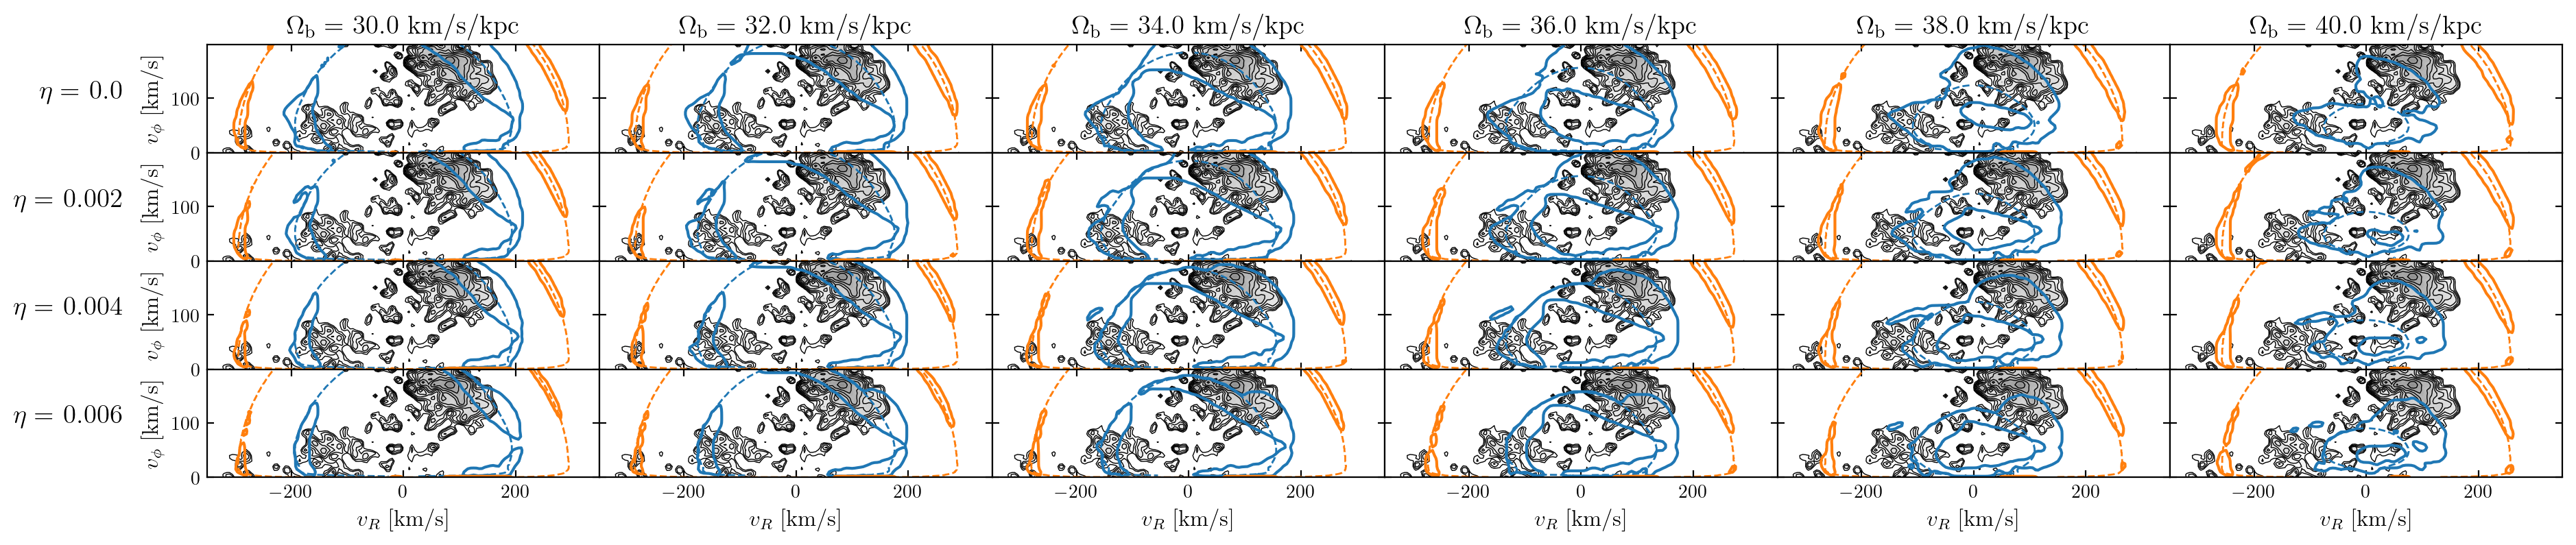

In [856]:
'''Plot contours and separatrices on a single plot for different pattern speeds etc.'''
from scipy.stats import binned_statistic_2d

fig, axs = plt.subplots(int((len(eta_array)+1)/2), int((len(Omega_b_array)+1)/2), figsize=(2*len(Omega_b_array)*(vR_bins[-1]-vR_bins[0])/700,2*len(eta_array)*(vphi_bins[-1]-vphi_bins[0])/700), sharex=True, sharey=True, squeeze=False, dpi=200)
plt.subplots_adjust(hspace=0, wspace=0)

vcirc_sun = 238
# ecc_cut = (vphi_data - vcirc_sun)**2 + vR_data**2 > 50**2

cut = (MH<-1)*(dist<1)#*ecc_cut#*(eta_data<0.98)#*(abs(ic[:,-1])<60)#*(eta < 0.9)#*(E_data/1e5>-0.8)*(E_data/1e5>-0.65)#(L_z_data<500)*(L_z_data>0)

# bins = np.linspace(-350, 350, 101)

# extent = [bins[0],bins[-1],bins[0],bins[-1]]

# # J_r_res_func = interp1d(J_phi_res_array, J_r_res_array[0], bounds_error=False)
# # cut_res = (abs(act_data[:,0] - J_r_res_func(L_z_data)) < 20)*cut*(L_z_data > 0)*(L_z_data < 1500)*(act_data[:,1] < 10)

# hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut], bins=(bins))

# hist = np.nan_to_num(hist)

# bincentres = 0.5*(bins[1:]+bins[:-1])
# hist_smooth = gaussian_filter(hist, 1.5)

# hist_antisym_smooth = hist_smooth - np.flip(hist_smooth, axis=0)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
# # hist_antisym_smooth = gaussian_filter(hist_antisym, 1.5)

bins = (vR_bins, vphi_bins)
hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut], bins=bins)
hist_antisym = 0.5 * (hist - np.flip(hist, axis=0))
hist_antisym[hist_antisym < 0] = 0
hist_antisym_smooth = gaussian_filter(hist_antisym, 1)


# ax.imshow(hist.T, extent=extent, interpolation='none', aspect='auto', origin='lower', norm=mcolors.LogNorm())
for ax in axs.flat:
    ax.contourf(vR_bincentres, vphi_bincentres, hist_antisym_smooth.T, levels=np.logspace(-0.1,1.5,50), cmap='Greys', norm=mcolors.LogNorm())
    ax.contour(vR_bincentres, vphi_bincentres, hist_antisym_smooth.T, levels=np.logspace(-0.1,1.5,20), colors='k', linewidths=0.5, norm=mcolors.LogNorm())
    ax.set_ylim(0, 199)

for ax in axs[-1].flat:
    ax.set_xlabel('$v_R$ [km/s]', fontsize=12)

# for ax in axs[:,0].flat:
#     ax.set_ylabel('$v_\phi$\n[km/s]', fontsize=16)

orbit_bincentres_R = 0.5*(vR_bins[1:]+vR_bins[:-1])
orbit_bincentres_phi = 0.5*(vphi_bins[1:]+vphi_bins[:-1])

# Plot orbits
# for i in range(N_grid_R*N_grid_phi):
#     col = i%N_grid
#     row = (i - col)/N_grid
    
    
    
#     if (col%((N_grid-1)/20) == 0)*(row%((N_grid-1)/20) == 0)*(vR_grid_flat[i]**2+vphi_grid_flat[i]**2 < 301**2):#(max(orbits[:,i,0]) < 20):
        
#         ax.plot(vR_grid_flat[i]-0.8*orbits[:,i,0], vphi_grid_flat[i]+0.8*orbits[:,i,1], lw=0.1, c='k')
        
#         ax.scatter(vR_grid_flat[i], vphi_grid_flat[i], marker='+', c='k', s=0.1, zorder=10)
res_index_list = [0, 0.5]
res_flag_list = [corot_flag_array, OLR_flag_array]#, dragged_flag_array]#, one_to_one_flag_array, ret_OLR_flag_array]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i in range(len(Omega_b_array)):

    if (i%2 == 0):
        axs[0,int(i/2)].set_title('$\Omega_\mathrm{b}=$ '+str(Omega_b_array[i])+' km/s/kpc', fontsize=14)
        
    for j in range(len(eta_array)):
        for k in range(len(res_flag_list)):
            if (i%2 == 0) and (j%2 ==0):
                hist, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag_list[k][i,j], statistic='mean', bins=(vR_bins, vphi_bins))
                hist_smooth = gaussian_filter(hist, 1)

                hist_antisym_smooth = hist_smooth - np.flip(hist_smooth, axis=0)
                hist_flip_smooth = np.flip(hist_smooth, axis=0)

                # ax.scatter(vR_grid_flat[corot_flag], vphi_grid_flat[corot_flag], c='tab:red', s=1, marker='s', alpha=1)
                axs[int(j/2),int(i/2)].contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k])

                # vR_res, vphi_res = calc_exact_res(Omega_b_array[i], pot_axi, res_index_list[k])
                axs[int(j/2),int(i/2)].plot(vR_res_array[i,k], vphi_res_array[i,k], ls='--', lw=1, color=colors[k])
                # axs[j,i].contour(orbit_bincentres_R, orbit_bincentres_phi, hist_
                # flip_smooth.T, levels=[0.5], colors=colors[k])

        # hist_OLR, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, OLR_flag_array[i,j], statistic='mean', bins=(orbit_bins_R, orbit_bins_phi))
        # hist_OLR_smooth = gaussian_filter(hist_OLR, 1)
        # # ax.scatter(vR_grid_flat[corot_flag], vphi_grid_flat[corot_flag], c='tab:red', s=1, marker='s', alpha=1)
        # axs[i,j].contour(orbit_bincentres_R, orbit_bincentres_phi, hist_OLR_smooth.T, levels=[0.5], colors='tab:red')

for j in range(len(eta_array)):
    if (j%2 == 0):
        axs[int(j/2),0].set_ylabel('$v_\phi$ [km/s]', fontsize=12)
        axs[int(j/2),0].text(-500, 100, '$\eta=$ '+str(eta_array[j]), fontsize=14, ha='right')

for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


In [82]:
'''Set up orbit integrations over grid and calculate separatrices for summary plot'''

# Choose grid over which to integrate orbits
vR_max = 400
vphi_min = -400
vphi_max = 400
grid_step = 5
N_grid_R = int(vR_max*2 / grid_step) + 1
N_grid_phi = int((vphi_max - vphi_min) / grid_step) + 1

# vR_bins = np.linspace(-vR_max, vR_max, N_grid_R)
# vphi_bins = np.linspace(vphi_min, vphi_max, N_grid_phi)

vR_bincentres = np.linspace(-vR_max, vR_max, N_grid_R)
vphi_bincentres = np.linspace(vphi_min, vphi_max, N_grid_phi)

vR_grid, vphi_grid = np.meshgrid(vR_bincentres, vphi_bincentres)

vR_bins = np.linspace(-vR_max-grid_step/2, vR_max+grid_step/2, N_grid_R+1)
vphi_bins = np.linspace(vphi_min-grid_step/2, vphi_max+grid_step/2, N_grid_phi+1)

vR_grid_flat = vR_grid.flatten()
vphi_grid_flat = vphi_grid.flatten()

snap = -2
Omega_b = Omega_b_sim[snap]
print('Omega_b =', Omega_b)
eta_sim = 0.003

Omega_b_array = [Omega_b]#np.linspace(30, 40, 11)
eta_array = [0, eta_sim]#np.linspace(0., 0.006, 7)#np.array([0., 0.002, 0.004, 0.006])
bar_angle = 30 * np.pi/180
R_sun = R_sun

int_time = 4
trajsize = 501

res_ratio_list = [0, 0.5, 1, 1.5]

res_flag_array = calc_res_flags(res_ratio_list, Omega_b_array, eta_array, pot_axi, vR_grid_flat, vphi_grid_flat, int_time=int_time, trajsize=trajsize)

# res_index_list = [0, 0.5]
# res_flag_list = [corot_flag, OLR_flag]

Omega_b = 32.50270916353844
20831 orbits complete (766.1 orbits/s)
20831 orbits complete (786.5 orbits/s)


<>:126: SyntaxWarning: invalid escape sequence '\O'
<>:126: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_80947/3426088662.py:126: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18, y=1.05)


6 orbits complete (500 orbits/s)


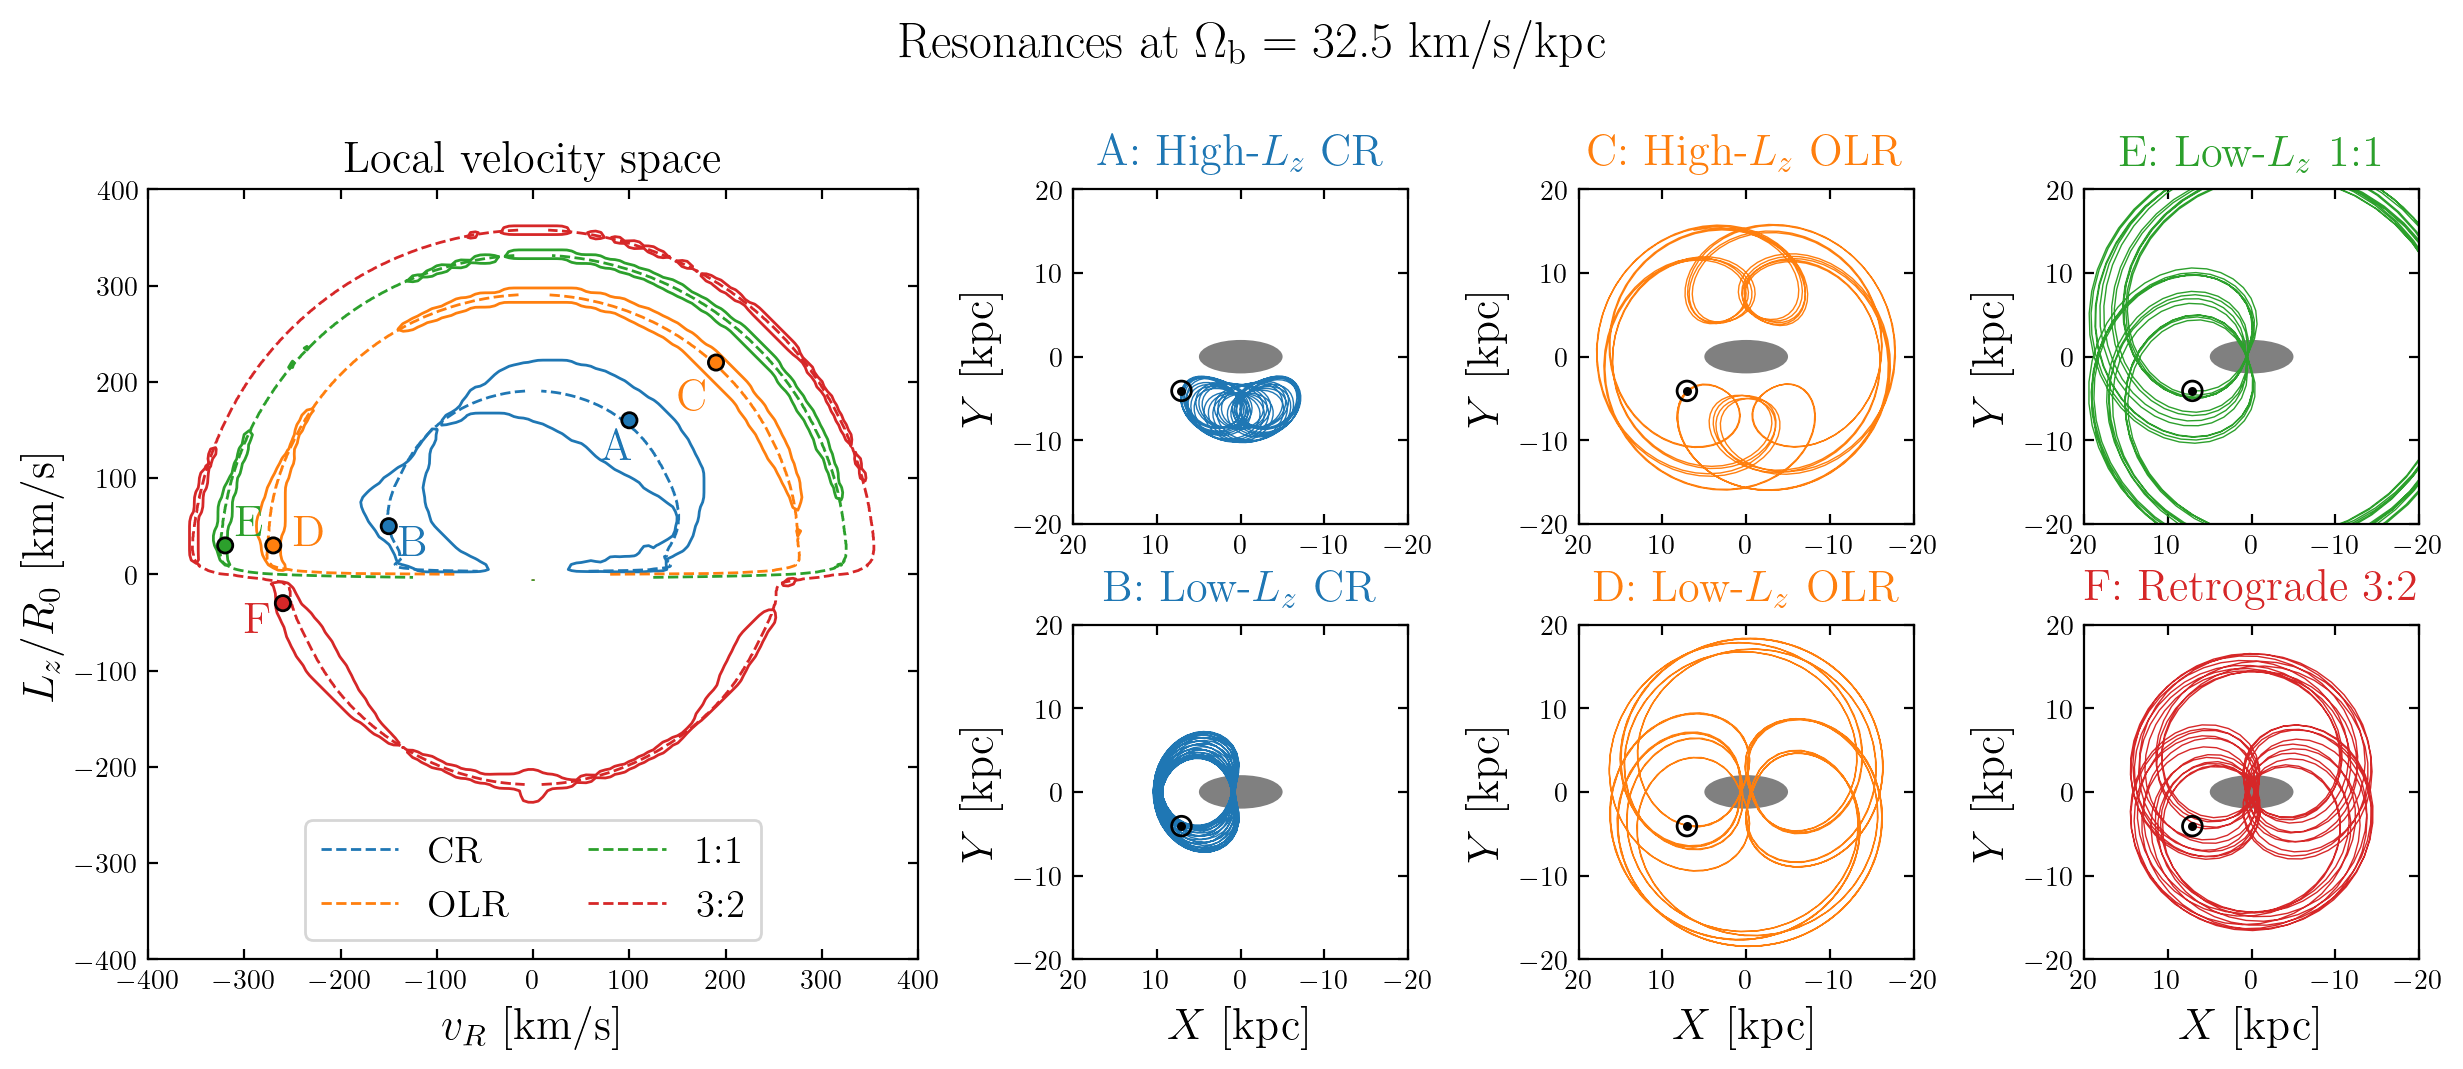

In [32]:
'''Plot only separatrices and examples of orbits'''

from matplotlib import gridspec
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.interpolate import RegularGridInterpolator

# Create a figure
fig = plt.figure(figsize=(15, 5), dpi=200)

# Create a GridSpec layout: 2 rows and 3 columns (last column is used by the top big panel)
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[2, 1, 1, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

ax_sep = plt.subplot(gs[:,0])

ax_1 = plt.subplot(gs[0, 1])
ax_2 = plt.subplot(gs[1, 1], sharex=ax_1, sharey=ax_1)
ax_3 = plt.subplot(gs[0, 2], sharex=ax_1, sharey=ax_1)
ax_4 = plt.subplot(gs[1, 2], sharex=ax_1, sharey=ax_1)
ax_5 = plt.subplot(gs[0, 3], sharex=ax_1, sharey=ax_1)
ax_6 = plt.subplot(gs[1, 3], sharex=ax_1, sharey=ax_1)

axs = [ax_sep, ax_1, ax_2, ax_3, ax_4, ax_5, ax_6]

bins = np.linspace(-400, 400, 101)
bincentres = 0.5*(bins[1:]+bins[:-1])

ax_sep.set_xlim(-400, 400)
ax_sep.set_ylim(-400, 400)

# Choose orbits to plot
peaks = np.array([[100, 160], [-150, 50], [190, 220], [-270, 30], [-320, 30], [-260, -30]])

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['CR', 'OLR', '1:1', '3:2']
fc = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green', 'tab:red']#, 'tab:red', 'tab:red']#['k', 'tab:blue', 'tab:red', 'tab:orange']
ec = ['k', 'k', 'k', 'k']
# ax_data.scatter(peaks[:,0], peaks[:,1], marker='o', s=50, fc=fc, ec=ec, zorder=10)
ax_sep.scatter(peaks[:,0], peaks[:,1], marker='o', fc=fc, ec=ec, s=30, zorder=10)

# Set up initial conditions
phi_sun = 2*np.pi-bar_angle

X_sun = R_sun * np.cos(phi_sun)
Y_sun = R_sun * np.sin(phi_sun)

vX_grid = peaks[:,0] * np.cos(-bar_angle) - peaks[:,1] * np.sin(-bar_angle)
vY_grid = peaks[:,0] * np.sin(-bar_angle) + peaks[:,1] * np.cos(-bar_angle)

ic_peaks = np.array([X_sun*np.ones(len(peaks)), Y_sun*np.ones(len(peaks)), np.zeros(len(peaks)), vX_grid, vY_grid, np.zeros(len(peaks))+1e-1]).T

orbits_peaks, ts = test_part_sim(ic_peaks, pot_Hunter, Omega=Omega_b, time=4, trajsize=1001)
af = agama.ActionFinder(pot_axi)
act, ang, freqs = af(orbits_peaks[:,4], angles=True)

theta_s = np.unwrap(2*ang[:,2] + 3*ang[:,0])


# Also plot separatrices
for k in range(len(res_flag_array)):
    hist, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag_array[k,0,0], statistic='mean', bins=(vR_bins, vphi_bins))
    hist_smooth = gaussian_filter(hist, 1)

    ax_sep.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)


# Also plot exact resonances in axisymmetric potential
for k in range(len(res_flag_array)):
    vR_res, vphi_res = calc_exact_res(Omega_b, pot_axi, res_ratio_list[k])

    ax_sep.plot(vR_res, vphi_res, ls='--', lw=1, color=colors[k], label=labels[k])


labels = ['A', 'B', 'C', 'D', 'E', 'F']
label_positions = np.array([[70, 120], [-140, 20], [150, 170], [-250, 30], [-310, 40], [-300, -60]])

for i in range(len(peaks)):
    t = ax_sep.text(label_positions[i,0], label_positions[i,1], labels[i], c=fc[i], fontsize=16)
        # ax.axline(label_positions[i])

from matplotlib.patches import Ellipse

for i in range(len(peaks)):
    axs[i+1].plot(orbits_peaks[:,i,0], orbits_peaks[:,i,1], c=fc[i], lw=0.5)
    axs[i+1].scatter(X_sun, Y_sun, ec='k', fc='none', s=50, zorder=10)
    axs[i+1].scatter(X_sun, Y_sun, c='k', marker='o', s=5, zorder=11)
    axs[i+1].set_xlim(20, -20)
    axs[i+1].set_ylim(-20, 20)

for ax in axs[1:]:
    ellipse = Ellipse((0,0), 10, 4, fc='grey')
    ax.add_patch(ellipse)

for ax in axs:
    ax.set_aspect('equal')
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


ax_sep.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax_sep.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

ax_2.set_xlabel('$X$ [kpc]', fontsize=16)
ax_4.set_xlabel('$X$ [kpc]', fontsize=16)
ax_6.set_xlabel('$X$ [kpc]', fontsize=16)

ax_1.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_2.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_3.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_4.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_5.set_ylabel('$Y$ [kpc]', fontsize=16)
ax_6.set_ylabel('$Y$ [kpc]', fontsize=16)

ax_sep.set_title('Local velocity space', fontsize=16)
ax_1.set_title('A: High-$L_z$ CR', fontsize=16, c=fc[0], y=1.02)
ax_2.set_title('B: Low-$L_z$ CR', fontsize=16, c=fc[1], y=1.02)
ax_3.set_title('C: High-$L_z$ OLR', fontsize=16, c=fc[2], y=1.02)
ax_4.set_title('D: Low-$L_z$ OLR', fontsize=16, c=fc[3], y=1.02)
ax_5.set_title('E: Low-$L_z$ 1:1', fontsize=16, c=fc[4], y=1.02)
ax_6.set_title('F: Retrograde 3:2', fontsize=16, c=fc[5], y=1.02)

ax_sep.legend(loc=8, fontsize=14, ncols=2)

fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18, y=1.05)


plt.savefig(figpath+'separatrices.pdf', bbox_inches='tight')

plt.show()
plt.close()


<>:116: SyntaxWarning: invalid escape sequence '\O'
<>:116: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_80947/196539399.py:116: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18)


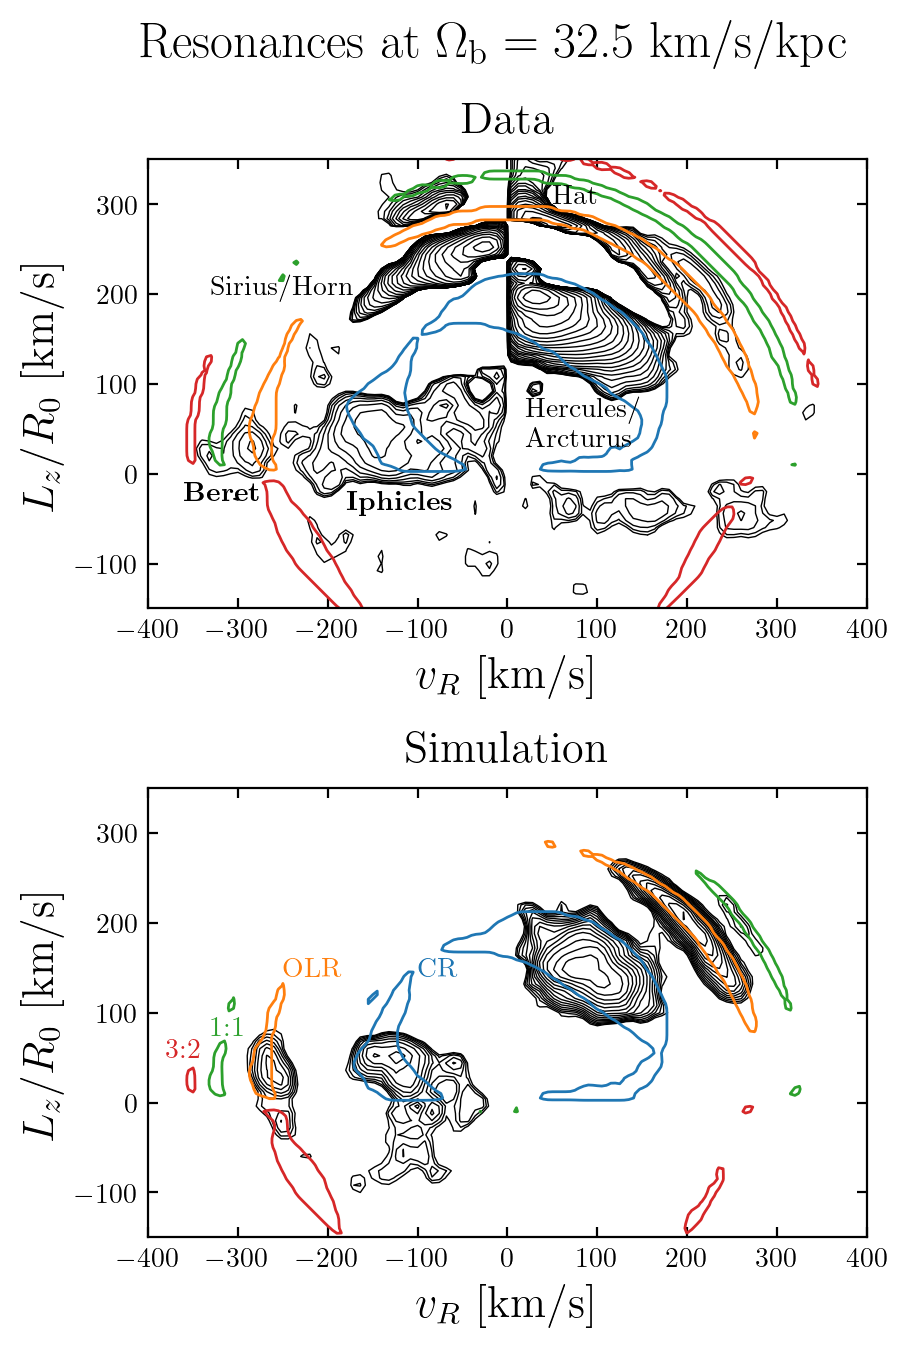

In [95]:
'''Plot antisymmetric distributions of data and simulations'''

from matplotlib import gridspec
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.interpolate import RegularGridInterpolator

fig, axs = plt.subplots(2, figsize=(5, 7), dpi=200)

plt.subplots_adjust(hspace=0.4, wspace=0.2)

ax_data = axs[0]
ax_sim = axs[1]

# Select radial, azimuthal and metallicity ranges in which to plot
MH_max = 10#-0.5
R_range = 1
z_max = 2
phi_range = np.pi/12


# Data
cut = (MH < MH_max)*(abs(R_data - R_sun) < R_range)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)#(dist<dist_limit)

bins = np.linspace(-400, 400, 101)
bincentres = 0.5*(bins[1:]+bins[:-1])

hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut]*R_data[cut]/R_sun, bins=bins)
hist_smooth = gaussian_filter(hist, 1)

hist_antisym = hist - np.flip(hist, axis=0)
hist_antisym_smooth = gaussian_filter(hist_antisym, 1)

# ax_data.contourf(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.3, 5, 30), cmap='Greys', norm=mcolors.LogNorm())
ax_data.contour(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.3, 5, 30), colors='k', linewidths=0.5)
ax_data.set_xlim(-400, 400)
ax_data.set_ylim(-150, 350)


# Simulation
cut = (abs(R_sim[snap] - R_sun) < R_range)*(abs(phi_sim[snap]%np.pi - 5/6*np.pi) < phi_range)*(abs(trajs[snap,:,2]) < z_max)

hist, _, _ = np.histogram2d(vR_sim[snap,cut], vphi_sim[snap,cut]*R_sim[snap,cut]/R_sun, bins=bins)
hist_smooth = gaussian_filter(hist, 1)

hist_antisym = hist - np.flip(hist, axis=0)
hist_antisym_smooth = gaussian_filter(hist_antisym, 1)

# ax_sim.contourf(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.3, 2, 20), cmap='Greys', norm=mcolors.LogNorm())
ax_sim.contour(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.9, 2, 20), colors='k', linewidths=0.5)
ax_sim.set_xlim(-400, 400)
ax_sim.set_ylim(-150, 350)


# ax_data.scatter(peaks[:,0], peaks[:,1], marker='o', fc=fc, ec=ec, s=30, zorder=10)
# ax_sim.scatter(peaks[:,0], peaks[:,1], marker='o', fc=fc, ec=ec, s=30, zorder=10)


# Also plot separatrices
for k in range(len(res_flag_array)):
    hist, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag_array[k,0,0], statistic='mean', bins=(vR_bins, vphi_bins))
    hist_smooth = gaussian_filter(hist, 1)

    # ax_data.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)
    ax_data.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)

    hist, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag_array[k,0,1], statistic='mean', bins=(vR_bins, vphi_bins))
    hist_smooth = gaussian_filter(hist, 1)

    # ax_data.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)
    ax_sim.contour(vR_bincentres, vphi_bincentres, hist_smooth.T, levels=[0.5], colors=colors[k], linewidths=1)


# Also plot exact resonances in axisymmetric potential
# for k in range(len(res_flag_array)):
#     vR_res, vphi_res = calc_exact_res(Omega_b, pot_axi, res_ratio_list[k])

#     ax_data.plot(vR_res, vphi_res, ls='--', lw=1, color=colors[k])
#     ax_sim.plot(vR_res, vphi_res, ls='--', lw=1, color=colors[k])


# Point labels
labels = ['A', 'B', 'C', 'D', 'E', 'F']
label_positions = np.array([[80, 40], [-200, 90], [170, 130], [-230, 10], [-360, -30], [-300, -70]])

# for i in range(len(peaks)):
    # ax_sim.text(label_positions[i,0], label_positions[i,1], labels[i], c=fc[i], fontsize=16)

ax_data.text(20, 30, 'Hercules/\nArcturus')
ax_data.text(-330, 200, 'Sirius/Horn')
ax_data.text(50, 300, 'Hat')

ax_data.text(-180, -40, '$\\bf{Iphicles}$')
ax_data.text(-360, -30, '$\\bf{Beret}$')

ax_sim.text(-100, 140, 'CR', color=colors[0])
ax_sim.text(-250, 140, 'OLR', color=colors[1])
ax_sim.text(-330, 75, '1:1', color=colors[2])
ax_sim.text(-380, 50, '3:2', color=colors[3])



for ax in axs:
    ax.set_aspect('equal')
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

ax_data.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax_sim.set_xlabel('$v_R$ [km/s]', fontsize=16)
ax_data.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)
ax_sim.set_ylabel('$L_z/R_0$ [km/s]', fontsize=16)

ax_data.set_title('Data', fontsize=16, y=1.02)
ax_sim.set_title('Simulation', fontsize=16, y=1.02)

fig.suptitle('Resonances at $\Omega_\mathrm{b}=$ '+f'{Omega_b:.1f}'+' km/s/kpc', fontsize=18)

plt.savefig(figpath+'data_sim_seps.pdf', bbox_inches='tight')


[32.50270916353844]
[[[ True]]]


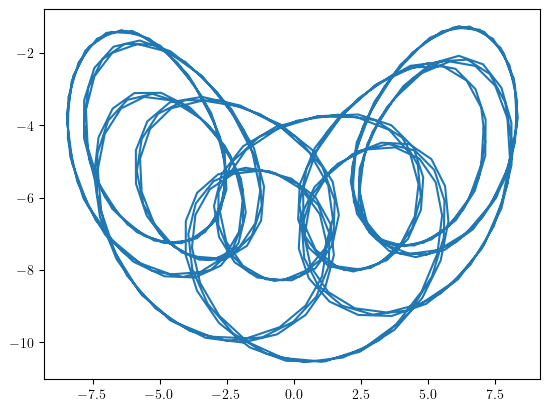

In [244]:
N_grid_R = 1
N_grid_phi = 1

print(Omega_b_array)

corot_flag, OLR_flag = calc_res_flags(Omega_b_array, eta_array, pot_axi, np.array([peaks[1,0]]), np.array([peaks[1,1]]), int_time=int_time, trajsize=trajsize)

print(corot_flag)

In [208]:
'''Functions to calculate OLR orbit in as a function of potential parameters and pattern speed'''
from scipy.interpolate import CubicSpline

# Function to calculate potential from local circular velocity and NFW scale radius
def make_pot(vcirc_sun, a_NFW, pot_axi_baryon):
    # Circular speed
    vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

    # DM halo density normalisation
    rho_0 = R_sun * vcirc_dark**2 / (4 * np.pi * agama.G * a_NFW**3) * (np.log(1 + R_sun/a_NFW) - 1/(1 + a_NFW/R_sun))**(-1)

    # Make DM potential
    pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

    # And total potential
    pot_mod = agama.Potential(pot_axi_baryon, pot_dark)

    return pot_mod

# Function to calculate exact OLR orbit in given axisymmetric potential with given pattern speed and Lz
def calc_OLR_orbit(pot_mod, Omega_b, Lz):
    # Create ActionFinder to compute frequencies
    af = agama.ActionFinder(pot_mod)

    # Make grid of initial conditions at Sun's radius
    N_grid = 10001
    vR_grid = np.linspace(100, 500, N_grid)
    ic = np.array([R_sun*np.ones(N_grid), np.zeros(N_grid), np.zeros(N_grid), vR_grid, Lz/R_sun*np.ones(N_grid), 1e-1*np.ones(N_grid)]).T

    act, ang, freq = af(ic, angles=True)

    res_ratio = -(freq[:,2] - Omega_b)/freq[:,0]

    OLR_dist = abs(res_ratio - 0.5)

    OLR_index = np.argmin(OLR_dist)
    OLR_ic = ic[OLR_index]
    OLR_orbit = agama.orbit(ic=OLR_ic, potential=pot_mod, Omega=Omega_b, time=2*np.pi/freq[OLR_index,0], trajsize=1001)[1]

    R_orbit = np.linalg.norm(OLR_orbit[:,0:2], axis=-1)
    R_hat = OLR_orbit[:,0:3] * [1, 1, 0] / R_orbit[:,None]
    vR_orbit = (OLR_orbit[:,3:6] * R_hat).sum(axis=-1)

    index_inner = np.argmin(vR_orbit)
    index_outer = np.argmax(R_orbit)
    R_orbit_cut = R_orbit[index_outer+1:index_inner]
    vR_orbit_cut = vR_orbit[index_outer+1:index_inner]

    order = np.argsort(R_orbit_cut)
    vR_func = CubicSpline(R_orbit_cut[order], -abs(vR_orbit_cut[order]))

    return vR_func


# Choose default potential
pot_axi_Hunter_baryon = agama.Potential(agama_pot_path+'MWPotentialHunter24_baryon_axi.ini')
pot_axi_baryon = pot_axi_Hunter_baryon

# Function to calculate model OLR orbit as a function of radius
def calc_model_func(theta, pot_axi_baryon=pot_axi_baryon, Lz=300):
    vcirc_sun, a_NFW, Omega_b = theta
    pot_mod = make_pot(vcirc_sun, a_NFW, pot_axi_baryon)
    vR_func = calc_OLR_orbit(pot_mod, Omega_b, Lz)
    return vR_func

# Function to calculate log likelihood
# theta = [vcirc_sun, a_NFW, Omega_b]
# x = R, y = vR
def calc_log_likelihood(theta, x, y, yerr):
    vcirc_sun, a_NFW, Omega_b = theta
    model_func = calc_model_func(theta)
    model = model_func(x)

    log_likelihood = -0.5 * ((y - model)**2 / yerr**2 + np.log(2*np.pi*yerr**2)).sum()

    return log_likelihood



/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_8724/4203781510.py:19: RuntimeWarning: invalid value encountered in divide
  hist_antisym = (hist - np.flip(hist, axis=1))/(hist + np.flip(hist, axis=1))#hist - np.flip(hist, axis=1)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))


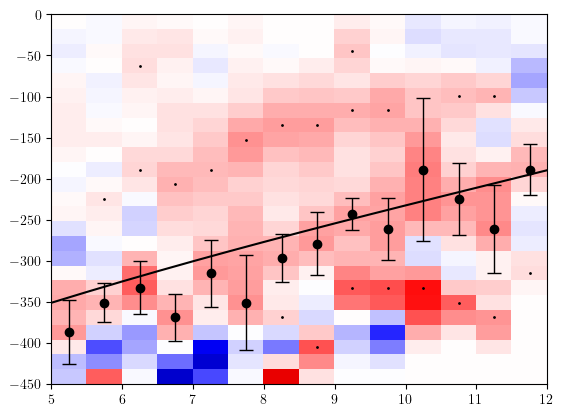

In [212]:
'''Generate data from antisymmetric distribution as function of radius'''
from scipy.signal import find_peaks, peak_widths

vR_bins = np.linspace(-450, 450, 51)
vphi_bins = np.linspace(0, 100, 11)

vR_binwidth = vR_bins[1] - vR_bins[0]

R_bins = np.linspace(5, 12, 15)
R_bincentres = (R_bins[1:] + R_bins[:-1])/2

#First plot R-vR antisymmetric histogram
cut = (MH < -1)*(abs(phi_data_sun)<np.pi/3)*(vphi_data > 0)*(abs(vphi_data) < 100)#*(eta_data<0.98)#*(logg<3)
hist, _, _ = np.histogram2d(R_data[cut], vR_data[cut], bins=(R_bins, vR_bins))

vR_bincentres = 0.5*(vR_bins[1:]+vR_bins[:-1])
vphi_bincentres = 0.5*(vphi_bins[1:]+vphi_bins[:-1])

hist_antisym = (hist - np.flip(hist, axis=1))/(hist + np.flip(hist, axis=1))#hist - np.flip(hist, axis=1)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
hist_antisym = np.nan_to_num(hist_antisym)
hist_antisym_smooth = gaussian_filter(hist_antisym, (0,1))

plt.imshow(hist_antisym_smooth.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', vmin=-1, vmax=1, origin='lower', interpolation='none', aspect='auto')

# Calculate a fiducial OLR orbit
pot_axi_Hunter = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')
vR_func = calc_OLR_orbit(pot_axi_Hunter, 33, 250)

plt.plot(R_bins, vR_func(R_bins), c='k')

# Loop over each R bin and locate peaks
x = R_bincentres
y = np.zeros(len(R_bincentres))
yerr = np.zeros(len(R_bincentres))


for i in range(len(R_bins)-1):
    hist_antisym_smooth[hist_antisym_smooth < 0] = 0

    peak_indices, peak_props = find_peaks(hist_antisym_smooth[i], prominence=0.05)

    widths, width_heights, left_ips, right_ips = peak_widths(hist_antisym_smooth[i], peak_indices, rel_height=np.exp(-0.5))

    vR_errors = widths * vR_binwidth / 2
    # errors_upper = (right_ips - peak_indices) * vR_binwidth
    # errors_lower = (peak_indices - left_ips) * vR_binwidth

    vR_peaks = vR_bincentres[peak_indices]

    vR_peaks_rel = vR_peaks - vR_func(R_bincentres[i])

    OLR_peak_index = np.argmin(abs(vR_peaks_rel))

    y[i] = vR_peaks[OLR_peak_index]
    yerr[i] = vR_errors[OLR_peak_index]
    
    # Plot data points and their errors along with other unused peaks
    plt.scatter(np.ones(len(peak_indices))*R_bincentres[i], vR_peaks, c='k', s=1)
    # plt.scatter(R_bincentres[i], vR_peaks[OLR_peak_index], c='k', s=10)
    # plt.errorbar(R_bincentres[i], vR_peaks[OLR_peak_index], vR_errors[OLR_peak_index], c='k')


plt.errorbar(x, y, yerr, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

plt.xlim(5, 12)
plt.ylim(-450, 0)

plt.show()
plt.close()


In [228]:
'''Calculate profile likelihood for fixed potential and varying pattern speed'''

Omega_b_grid = np.linspace(30, 40, 11)
a_NFW_grid = np.linspace(10, 30, 11)

log_likelihood_array = np.zeros((len(Omega_b_grid), len(a_NFW_grid)))

for i in range(len(Omega_b_array)):
    for j in range(len(a_NFW_grid)):
        theta = [232.6, a_NFW_grid[j], Omega_b_grid[i]]
        log_likelihood_array[i,j] = calc_log_likelihood(theta, x, y, yerr)

    # vR_func = calc_model_func(theta)


# plt.plot(Omega_b_array, np.exp(log_likelihood_array))



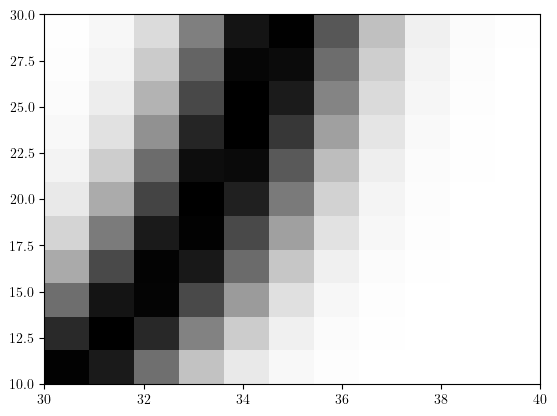

In [229]:
plt.imshow(np.exp(log_likelihood_array.T), extent=[Omega_b_array[0], Omega_b_array[-1], a_NFW_grid[0], a_NFW_grid[-1]], origin='lower', aspect='auto', cmap='Greys', interpolation='none')

1100777906065.1812
37232854.58117214
238.4014350720196


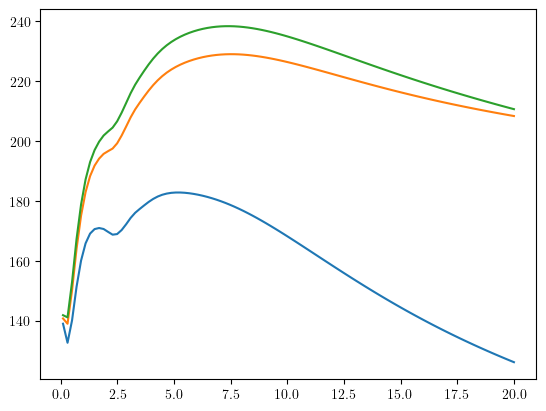

In [39]:
'''Plot rotation curves of different potentials'''
import astropy.units as u

pot_axi_Portail = agama.Potential(agama_pot_path+'Portail17_axi.ini')
pot_axi_Hunter = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')
pot_axi_Hunter_baryon = agama.Potential(agama_pot_path+'MWPotentialHunter24_baryon_axi.ini')

# Create NFW
M_tot_Hunter_baryon = -200**2 * pot_axi_Hunter_baryon.force(np.array([200, 0, 0]).T)[0] / agama.G


M_vir = 1.17e12
M_NFW = M_vir - M_tot_Hunter_baryon

print(M_NFW)

c_NFW = 7#10.9

from astropy.constants import G
from astropy.cosmology import WMAP9 as cosmo

H = cosmo.H(0)
rho_crit = 3 * H**2 / (8 * np.pi * G)

R_vir = ((M_vir*u.Msun / (4/3 * np.pi * 200 * rho_crit))**(1/3)).to(u.kpc).value

a_NFW = 8.1
vcirc_Sun = 238
vcirc_baryon = (-R_sun * pot_axi_Hunter_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
vcirc_dark = (vcirc_Sun**2 - vcirc_baryon**2)**0.5

rho_0 = R_sun * vcirc_dark**2 / (4 * np.pi * agama.G * a_NFW**3) * (np.log(1 + R_sun/a_NFW) - 1/(1 + a_NFW/R_sun))**(-1)

print(rho_0)


# pot_dark = agama.Potential(type='NFW', mass=M_vir, scaleRadius=a_NFW)
pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

pot_mod = agama.Potential(pot_axi_Hunter_baryon, pot_dark)

R_grid = np.linspace(0.1, 20, 101)

vcirc_Hunter_baryon = (-R_grid * pot_axi_Hunter_baryon.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5
vcirc_Hunter = (-R_grid * pot_axi_Hunter.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5
vcirc_mod = (-R_grid * pot_mod.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5

M_enc_Hunter_baryon = -R_grid**2 * pot_axi_Hunter_baryon.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0] / agama.G
M_enc_Hunter = -R_grid**2 * pot_axi_Hunter.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0] / agama.G
M_enc_mod = -R_grid**2 * pot_mod.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0] / agama.G

plt.plot(R_grid, vcirc_Hunter_baryon)
plt.plot(R_grid, vcirc_Hunter)
plt.plot(R_grid, vcirc_mod)

print(np.max(vcirc_mod))

# plt.plot(R_grid, M_enc_Hunter_baryon)
# plt.plot(R_grid, M_enc_Hunter)
# plt.plot(R_grid, M_enc_mod)
# plt.xscale('log')
# plt.yscale('log')
# plt.axis('equal')
plt.show()
plt.close()




<>:124: SyntaxWarning: invalid escape sequence '\O'
<>:133: SyntaxWarning: invalid escape sequence '\m'
<>:136: SyntaxWarning: invalid escape sequence '\o'
<>:138: SyntaxWarning: invalid escape sequence '\m'
<>:139: SyntaxWarning: invalid escape sequence '\O'
<>:124: SyntaxWarning: invalid escape sequence '\O'
<>:133: SyntaxWarning: invalid escape sequence '\m'
<>:136: SyntaxWarning: invalid escape sequence '\o'
<>:138: SyntaxWarning: invalid escape sequence '\m'
<>:139: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_1207/1696712101.py:124: SyntaxWarning: invalid escape sequence '\O'
  cbar.set_label('$-(\Omega_\phi-\Omega_\mathrm{b})/\Omega_R-1/2$', fontsize=16)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_1207/1696712101.py:133: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel('$v_\mathrm{circ}$ [km/s]', fontsize=16)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_1207/1696712101.py:136: S

238.0000098845252
238.00000804594504
238.0000063011226
238.00000454438415
238.00000292801877
238.0000014758178
238.00000019295553
237.99999907403728
237.99999822100503
237.9999973985744
237.99999669885818


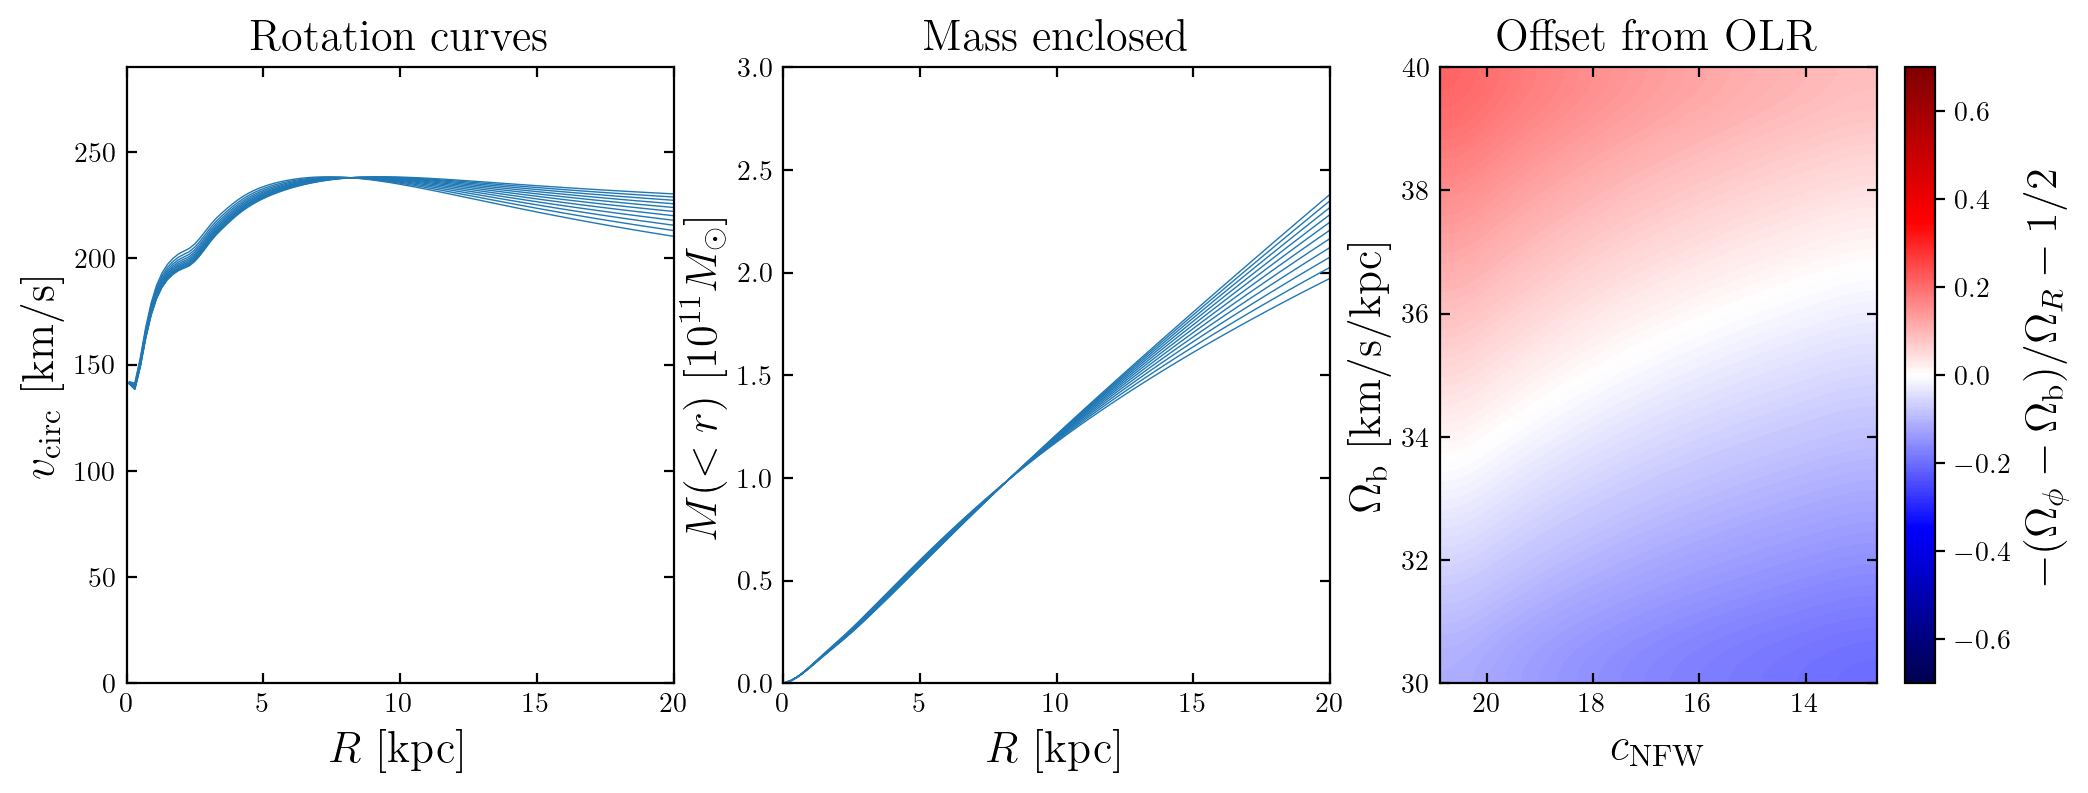

In [55]:
'''Constrain potential + Omega_b using OLR overdensity'''

# Calculate critical density for NFW calculations
from astropy.constants import G
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

H = cosmo.H(0)
rho_crit = (3 * H**2 / (8 * np.pi * G)).to(u.Msun/(u.kpc)**3).value

# Select peak [REPLACE WITH KDE FOR MORE PRECISION]
OLR_peak = peaks[3]

pot_axi_path = pot_axi_Hunter_path
pot_axi = agama.Potential(file=pot_axi_path)
pot_axi_Hunter_baryon = agama.Potential(agama_pot_path+'MWPotentialHunter24_baryon_axi.ini')
vcirc_grid = np.linspace(220, 250, 11)
Omega_b_grid = np.linspace(30, 40, 11)

vcirc_fid = (-R_sun * pot_axi.force(np.array([R_sun, 0, 0]).T)[0])**0.5

# vcirc_grid = np.array([238])
a_NFW_grid = np.linspace(8, 18, 11)
c_NFW_grid = np.zeros(len(a_NFW_grid))
R_200_grid = np.zeros(len(a_NFW_grid))
M_200_grid = np.zeros(len(a_NFW_grid))



# scale_grid = np.array([(vcirc_grid / vcirc_fid)**2, vcirc_grid*0+1]).T

OLR_dist_array = np.zeros((len(a_NFW_grid), len(Omega_b_grid)))

fig, axs = plt.subplots(1, 3, figsize=(12,4), dpi=200)


for i in range(len(a_NFW_grid)):
    

    # Calculate NFW density normalisation from fixed rotation curve
    a_NFW = a_NFW_grid[i]
    vcirc_Sun = 238
    vcirc_baryon = (-R_sun * pot_axi_Hunter_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_Sun**2 - vcirc_baryon**2)**0.5

    rho_0 = R_sun * vcirc_dark**2 / (4 * np.pi * agama.G * a_NFW**3) * (np.log(1 + R_sun/a_NFW) - 1/(1 + a_NFW/R_sun))**(-1)

    # Also calculate virial mass
    y_grid = np.linspace(1e-10, 100, 10001)
    rho_mean = 3 * rho_0 * y_grid**(-3) * (np.log(1 + y_grid) - y_grid/(1 + y_grid))
    index_200 = np.argmin(abs(rho_mean - 200*rho_crit))
    R_200 = y_grid[index_200] * a_NFW
    c_NFW = R_200 / a_NFW
    M_200 = 4/3 * np.pi * R_200**3 * rho_mean[index_200]

    c_NFW_grid[i] = c_NFW
    R_200_grid[i] = R_200
    M_200_grid[i] = M_200


    pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

    pot_mod = agama.Potential(pot_axi_Hunter_baryon, pot_dark)

    # pot_mod = agama.Potential(file=pot_axi_path, scale=scale_grid[i])

    af = agama.ActionFinder(pot_mod)

    R_grid = np.linspace(0.1, 20, 101)
    vcirc_mod = (-R_grid * pot_mod.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5
    M_enc_mod = pot_mod.enclosedMass(R_grid) #-R_grid**2 * pot_mod.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0] / agama.G

    axs[0].plot(R_grid, vcirc_mod, c='tab:blue', lw=0.5)
    axs[1].plot(R_grid, M_enc_mod/1e11, c='tab:blue', lw=0.5)

    vcirc_Sun = (-R_sun * pot_mod.force(np.array([R_sun, 0, 0]).T)[0])**0.5

    print(vcirc_Sun)

    vR_OLR = OLR_peak[0]
    vphi_OLR = OLR_peak[1]

    act, ang, freq = af([R_sun,0,0,vR_OLR,vphi_OLR,0], angles=True)

    freq_ratio = -(freq[2] - Omega_b_grid)/freq[0]

    OLR_dist_array[i] = freq_ratio - 0.5

# vcirc_Hunter = (-R_grid * pot_axi_Hunter.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5
# axs[0].plot(R_grid, vcirc_Hunter, c='grey', lw=0.5)

plot = axs[2].imshow(OLR_dist_array.T, extent=[c_NFW_grid[0], c_NFW_grid[-1], Omega_b_grid[0], Omega_b_grid[-1]], origin='lower', aspect='auto', cmap='seismic', vmin=-0.7, vmax=0.7, interpolation='bicubic')


# # Overplot measurements of circular velocity and pattern speed
# vcirc_mean = 236.9
# vcirc_std = 4.2

# vcirc_grid_fine = np.linspace(vcirc_grid[0], vcirc_grid[-1], 101)
# vcirc_measurement = np.exp(-(vcirc_grid_fine - vcirc_mean)**2 / (2*vcirc_std**2))

# axs[1].plot(vcirc_grid_fine, vcirc_measurement+Omega_b_grid[0], c='k', lw=0.9)
# axs[1].axvline(vcirc_mean, ls='--', c='k', lw=0.5)

# Omega_b_mean = 35.5
# Omega_b_std = 0.8

# Omega_b_grid_fine = np.linspace(Omega_b_grid[0], Omega_b_grid[-1], 101)
# Omega_b_measurement = np.exp(-(Omega_b_grid_fine - Omega_b_mean)**2 / (2*Omega_b_std**2))

# axs[1].plot(Omega_b_measurement*2+vcirc_grid[0], Omega_b_grid_fine, c='k', lw=0.9)
# axs[1].axhline(Omega_b_mean, ls='--', c='k', lw=0.5)

# from matplotlib.patches import Ellipse
# patch = Ellipse((vcirc_mean, Omega_b_mean), 2*vcirc_std, 2*Omega_b_std, fc='none', ec='k')
# axs[1].add_patch(patch)
# patch = Ellipse((vcirc_mean, Omega_b_mean), 4*vcirc_std, 4*Omega_b_std, fc='none', ec='k')
# axs[1].add_patch(patch)



cbar = plt.colorbar(plot, cax=None, ax=axs[2])

cbar.set_label('$-(\Omega_\phi-\Omega_\mathrm{b})/\Omega_R-1/2$', fontsize=16)

axs[0].set_xlim(0, 20)
axs[0].set_ylim(0, 290)
axs[1].set_xlim(0, 20)
axs[1].set_ylim(0, 3)


axs[0].set_xlabel('$R$ [kpc]', fontsize=16)
axs[0].set_ylabel('$v_\mathrm{circ}$ [km/s]', fontsize=16)

axs[1].set_xlabel('$R$ [kpc]', fontsize=16)
axs[1].set_ylabel('$M(<r)$ [$10^{11} M_\odot$]', fontsize=16)

axs[2].set_xlabel('$c_\mathrm{NFW}$', fontsize=16)
axs[2].set_ylabel('$\Omega_\mathrm{b}$ [km/s/kpc]', fontsize=16)

axs[0].set_title('Rotation curves', fontsize=16)
axs[1].set_title('Mass enclosed', fontsize=16)
axs[2].set_title('Offset from OLR', fontsize=16)

for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

plt.show()
plt.close()



In [87]:
'''Define likelihood function based on symmetry of distribution OUTSIDE resonances'''
# from scipy.ndimage import gaussian_filter
# from scipy.special import factorial

# def calc_log_likelihood(vR, vphi, bins, hist_res_sym_smooth):

#     # First define model PDF outside resonances: this is the distribution of stars in (vR, vphi) symmetrised over vR
#     # Calculate and smooth histogram
#     hist, _, _ = np.histogram2d(vR, vphi, bins=bins)
#     hist_smooth = gaussian_filter(hist, sigma=0.5)

#     # Normalised histogram
#     hist_norm = hist_smooth / np.sum(hist_smooth)

#     # Symmetrised histogram
#     # hist_sym = 0.5 * (hist + np.flip(hist, axis=0))

#     # Normalised symmetrised histogram
#     hist_sym_norm = 0.5 * (hist_norm + np.flip(hist_norm, axis=0))
#     # hist_sym_norm = hist_sym / np.sum(hist_sym)

#     # Create model from true and symmetrised data distributions, with contributions modulated by smooth resonance flag
#     model_unnorm = hist_sym_norm * (1 - hist_res_sym_smooth) + hist_norm * hist_res_sym_smooth

#     # Normalise model to same total count as data
#     model = model_unnorm / model_unnorm.sum() * hist.sum()

#     # # Calculate mask for non-resonant orbits
#     # mask_res = cut_res.reshape(len(vphi_bins)-1, len(vR_bins)-1).T

#     # # Replace resonant regions with true distribution
#     # model = np.copy(hist_sym_norm)
#     # model[mask_res] = 0 #hist_norm #hist_sym_norm_res_tot / mask_res.sum()
#     # model += hist_norm*mask_res

#     # Calculate log-likelihoods in each bin, weighting by number in bin and ignoring if in a resonance
#     # log_likelihood_bin = hist * np.log(model) - model - np.log(factorial(hist))
#     data = hist_smooth
#     residuals = data - model
#     log_likelihood_bin = - (data - model)**2 / (2 * (model + 1e-10)) - 0.5 * np.log(2*np.pi*(model + 1e-10))
#     # print(log_likelihood_bin.sum())

#     # # Also calculate log likelihood if model is perfect (to normalise by for clarity)
#     # log_likelihood_perfect = hist * np.nan_to_num(np.log(hist_norm))

#     plt.imshow(log_likelihood_bin.T, origin='lower', cmap='seismic', interpolation='none', vmin=-10, vmax=10)
#     plt.show()
#     plt.close()

#     # Sum over all bins
#     log_likelihood_tot = log_likelihood_bin.sum()

#     return log_likelihood_tot



from scipy.special import bdtr, comb, ndtr

def calc_log_likelihood(vR, vphi, bins, hist_res_sym_smooth):

    # First define model PDF outside resonances: this is the distribution of stars in (vR, vphi) symmetrised over vR
    # Calculate and smooth histogram
    hist, _, _ = np.histogram2d(vR, vphi, bins=bins)
    hist_smooth = gaussian_filter(hist, sigma=0.5)

    hist_sym = 0.5 * (hist + np.flip(hist, axis=0))
    hist_sym_smooth = 0.5 * (hist_smooth + np.flip(hist_smooth, axis=0))

    # Calculate probabilities from cumulative binomial distribution
    # n = 2*hist_sym
    # k = np.minimum(hist, np.flip(hist, axis=0))

    # prob = bdtr(k, n, 0.5) * 2

    # # If n is even and k=n/2, subtract the probability of the double-counted middle value
    # prob[k==n/2] -= (comb(n, k) * 0.5**n)[k==n/2]

    # prob = prob #* (1 - hist_res_sym_smooth) + hist_res_sym_smooth


    # OR: use Gaussian approximation to binomial distribution
    # n = 2*hist_sym
    # p = 0.5
    # mu = n * p
    # var = n * p*(1-p) + n   # Extra term n is due to Poisson noise associated with binning (???)

    # x = np.minimum(hist, np.flip(hist, axis=0))
    # z = (x - mu) / var**0.5
    # prob = ndtr(z) * 2

    # prob = prob * (1 - hist_res_sym_smooth) + hist_res_sym_smooth

    # prob = np.nan_to_num(prob, nan=1)

    # print(np.mean(prob))


    # log_likelihood_tot = 0.5 * np.log(prob).sum()
    
    # OR: simply calculate the probability for the whole sample outside the resonances
    hist_nonres = hist_smooth*(1 - hist_res_sym_smooth)

    n = hist_nonres.sum()
    p = 0.5
    mu = n * p
    var = n * p*(1-p)

    vR_bins = bins[0]
    vR_bincentres = 0.5*(vR_bins[1:] + vR_bins[:-1])

    x = np.minimum((hist_nonres[vR_bincentres>0]).sum(), (hist_nonres[vR_bincentres<0]).sum())
    z = (x - mu) / var**0.5
    prob = ndtr(z)

    print(prob)

    log_likelihood_tot = np.log(prob)

    plt.close()

    return log_likelihood_tot



# vR_max = 350
# vphi_min = -80
# vphi_max = 200

# vR_bins = np.linspace(-vR_max, vR_max, 101)
# vphi_bins = np.linspace(vphi_min, vphi_max, 101)
# log_likelihood_bins = (vR_bins, vphi_bins)

# cut = (MH > -10)*(MH < -1)*(dist<1)*(abs(vR_data)<vR_max)*(vphi_data>vphi_min)*(vphi_data<vphi_max)#*(eta_data<0.98)#*(logg<3)

# calc_log_likelihood(vR_data[cut], vphi_data[cut], bins)

In [505]:
'''Define function to calculate overlap between antisymmetric overdensities and resonances'''
# from scipy.ndimage import gaussian_filter
# from scipy.special import factorial

def calc_overlap(vR, vphi, bins, hist_res_smooth):

    # Calculate antisymmetric histogram
    hist, _, _ = np.histogram2d(vR, vphi, bins=bins)
    hist_antisym = 0.5 * (hist - np.flip(hist, axis=0))
    hist_antisym[hist_antisym < 0] = 0
    hist_antisym_smooth = gaussian_filter(hist_antisym, 1)

    # # Set all negative parts to zero (no loss of information - positive excess used instead)
    hist_antisym_smooth[hist_antisym_smooth < 1] = 0

    # Divide up antisymmetrised histogram into different resonant regions
    hist_antisym_smooth_CR = hist_antisym_smooth * (vR_grid.T > -250)
    hist_antisym_smooth_CR_0 = hist_antisym_smooth * (vR_grid.T > 0)
    hist_antisym_smooth_CR_1 = hist_antisym_smooth * (vR_grid.T > -250) * (vR_grid.T < 0)
    hist_antisym_smooth_OLR = hist_antisym_smooth * (vR_grid.T  < -250)

    # Normalise histograms
    hist_antisym_smooth_all = hist_antisym_smooth / hist_antisym_smooth.sum()
    hist_antisym_smooth_CR = hist_antisym_smooth_CR / hist_antisym_smooth_CR.sum()
    hist_antisym_smooth_CR_0 = hist_antisym_smooth_CR_0 / hist_antisym_smooth_CR_0.sum()
    hist_antisym_smooth_CR_1 = hist_antisym_smooth_CR_1 / hist_antisym_smooth_CR_1.sum()
    hist_antisym_smooth_OLR = hist_antisym_smooth_OLR / hist_antisym_smooth_OLR.sum()

    # hist_CR_smooth_norm = hist_res_smooth[0] / hist_res_smooth[0].sum()
    # hist_OLR_smooth_norm = hist_res_smooth[1] / hist_res_smooth[1].sum()

    # Calculate overlap of resonance flag and antisymmetrised histogram
    overlap_all = hist_res_smooth * hist_antisym_smooth_all
    overlap_CR = hist_res_smooth * hist_antisym_smooth_CR
    overlap_CR_0 = hist_res_smooth * hist_antisym_smooth_CR_0
    overlap_CR_1 = hist_res_smooth * hist_antisym_smooth_CR_1
    overlap_OLR = hist_res_smooth * hist_antisym_smooth_OLR

    overlap_tot_all = overlap_all.sum()
    overlap_tot_CR = overlap_CR.sum()
    overlap_tot_CR_0 = overlap_CR_0.sum()
    overlap_tot_CR_1 = overlap_CR_1.sum()
    overlap_tot_OLR = overlap_OLR.sum()

    print(overlap_tot_CR_0)

    overlap_array = np.array([overlap_tot_CR_0, overlap_tot_CR_1, overlap_tot_OLR])

    # log_likelihood_list = [np.log(prob_CR_0), np.log(prob_CR_1), np.log(prob_OLR)]
    # print(hist_antisym_smooth_CR.sum())

    # print(prob_CR_0)
    # print(log_likelihood_list[0])

    # plt.imshow(overlap_CR_0.T, origin='lower', cmap='gray_r', interpolation='none', vmin=0, vmax=0.1)
    # plt.show()
    # plt.close()
    
    return overlap_array



In [506]:
'''Calculate overlap'''
from scipy.stats import binned_statistic_2d

# Cut data
cut = (MH < -1)*(dist<2)

# Save log likelihood separately for different resonances
log_likelihood_corot_array = np.zeros((len(Omega_b_array), len(eta_array)))
log_likelihood_OLR_array = np.zeros((len(Omega_b_array), len(eta_array)))
overlap_array = np.zeros((len(Omega_b_array), len(eta_array), 3))

# Loop over all pattern speeds (or bar angles, potentials, etc.)
for i in range(len(Omega_b_array)):
    for j in range(len(eta_array)):

        res_flag = np.logical_or(corot_flag_array[i,j], OLR_flag_array[i,j])
        res_flag = np.logical_or(one_to_one_flag_array[i,j], res_flag)

        # Smooth resonance flag over the scale of a pixel
        hist_res, _, _, _ = binned_statistic_2d(vR_grid_flat, vphi_grid_flat, res_flag, statistic='mean', bins=(vR_bins, vphi_bins))
        # hist_res_sym = np.logical_or(hist_res, np.flip(hist_res, axis=0))
        
        hist_res_smooth = gaussian_filter(hist_res.astype(float), 1)

        overlap_array[i,j] = calc_overlap(vR_data[cut], vphi_data[cut], bins=(vR_bins, vphi_bins), hist_res_smooth=hist_res_smooth)

        # print(log_likelihood_array[i,j])

print(overlap_array.shape)

0.4203082781001507
0.3983323299832912
0.3645339516159233
0.32838551125976273
0.2964638595592172
0.2537408369749106
0.19816694437715085
0.5856512181563392
0.5752737265438487
0.5399060170833553
0.5054245864147014
0.4769842013819523
0.41340389044415615
0.33954041763343673
0.7274554892384497
0.7161193283653413
0.691310848972563
0.6651247891491192
0.6318851850563755
0.5418188336022527
0.45881455964537
0.8261403039633785
0.8208313302505658
0.8048841198502353
0.7827471963534464
0.7276826959319644
0.6086519901854831
0.5161412892518874
0.8613960270674988
0.8588313824934967
0.8498483450240444
0.8324138698364185
0.7425292222192138
0.6031142155935937
0.4930553992859175
0.8643439936321456
0.8606185572243747
0.8501248666103799
0.8154756636964884
0.7015523538061309
0.5578458121924723
0.4340835582373603
0.8315227250906938
0.8296942491502436
0.8217724724584171
0.7746842584627404
0.6475397920314611
0.4950447378387025
0.37206892239913986
0.7613134243460224
0.759460020395188
0.7472010197871951
0.702825469

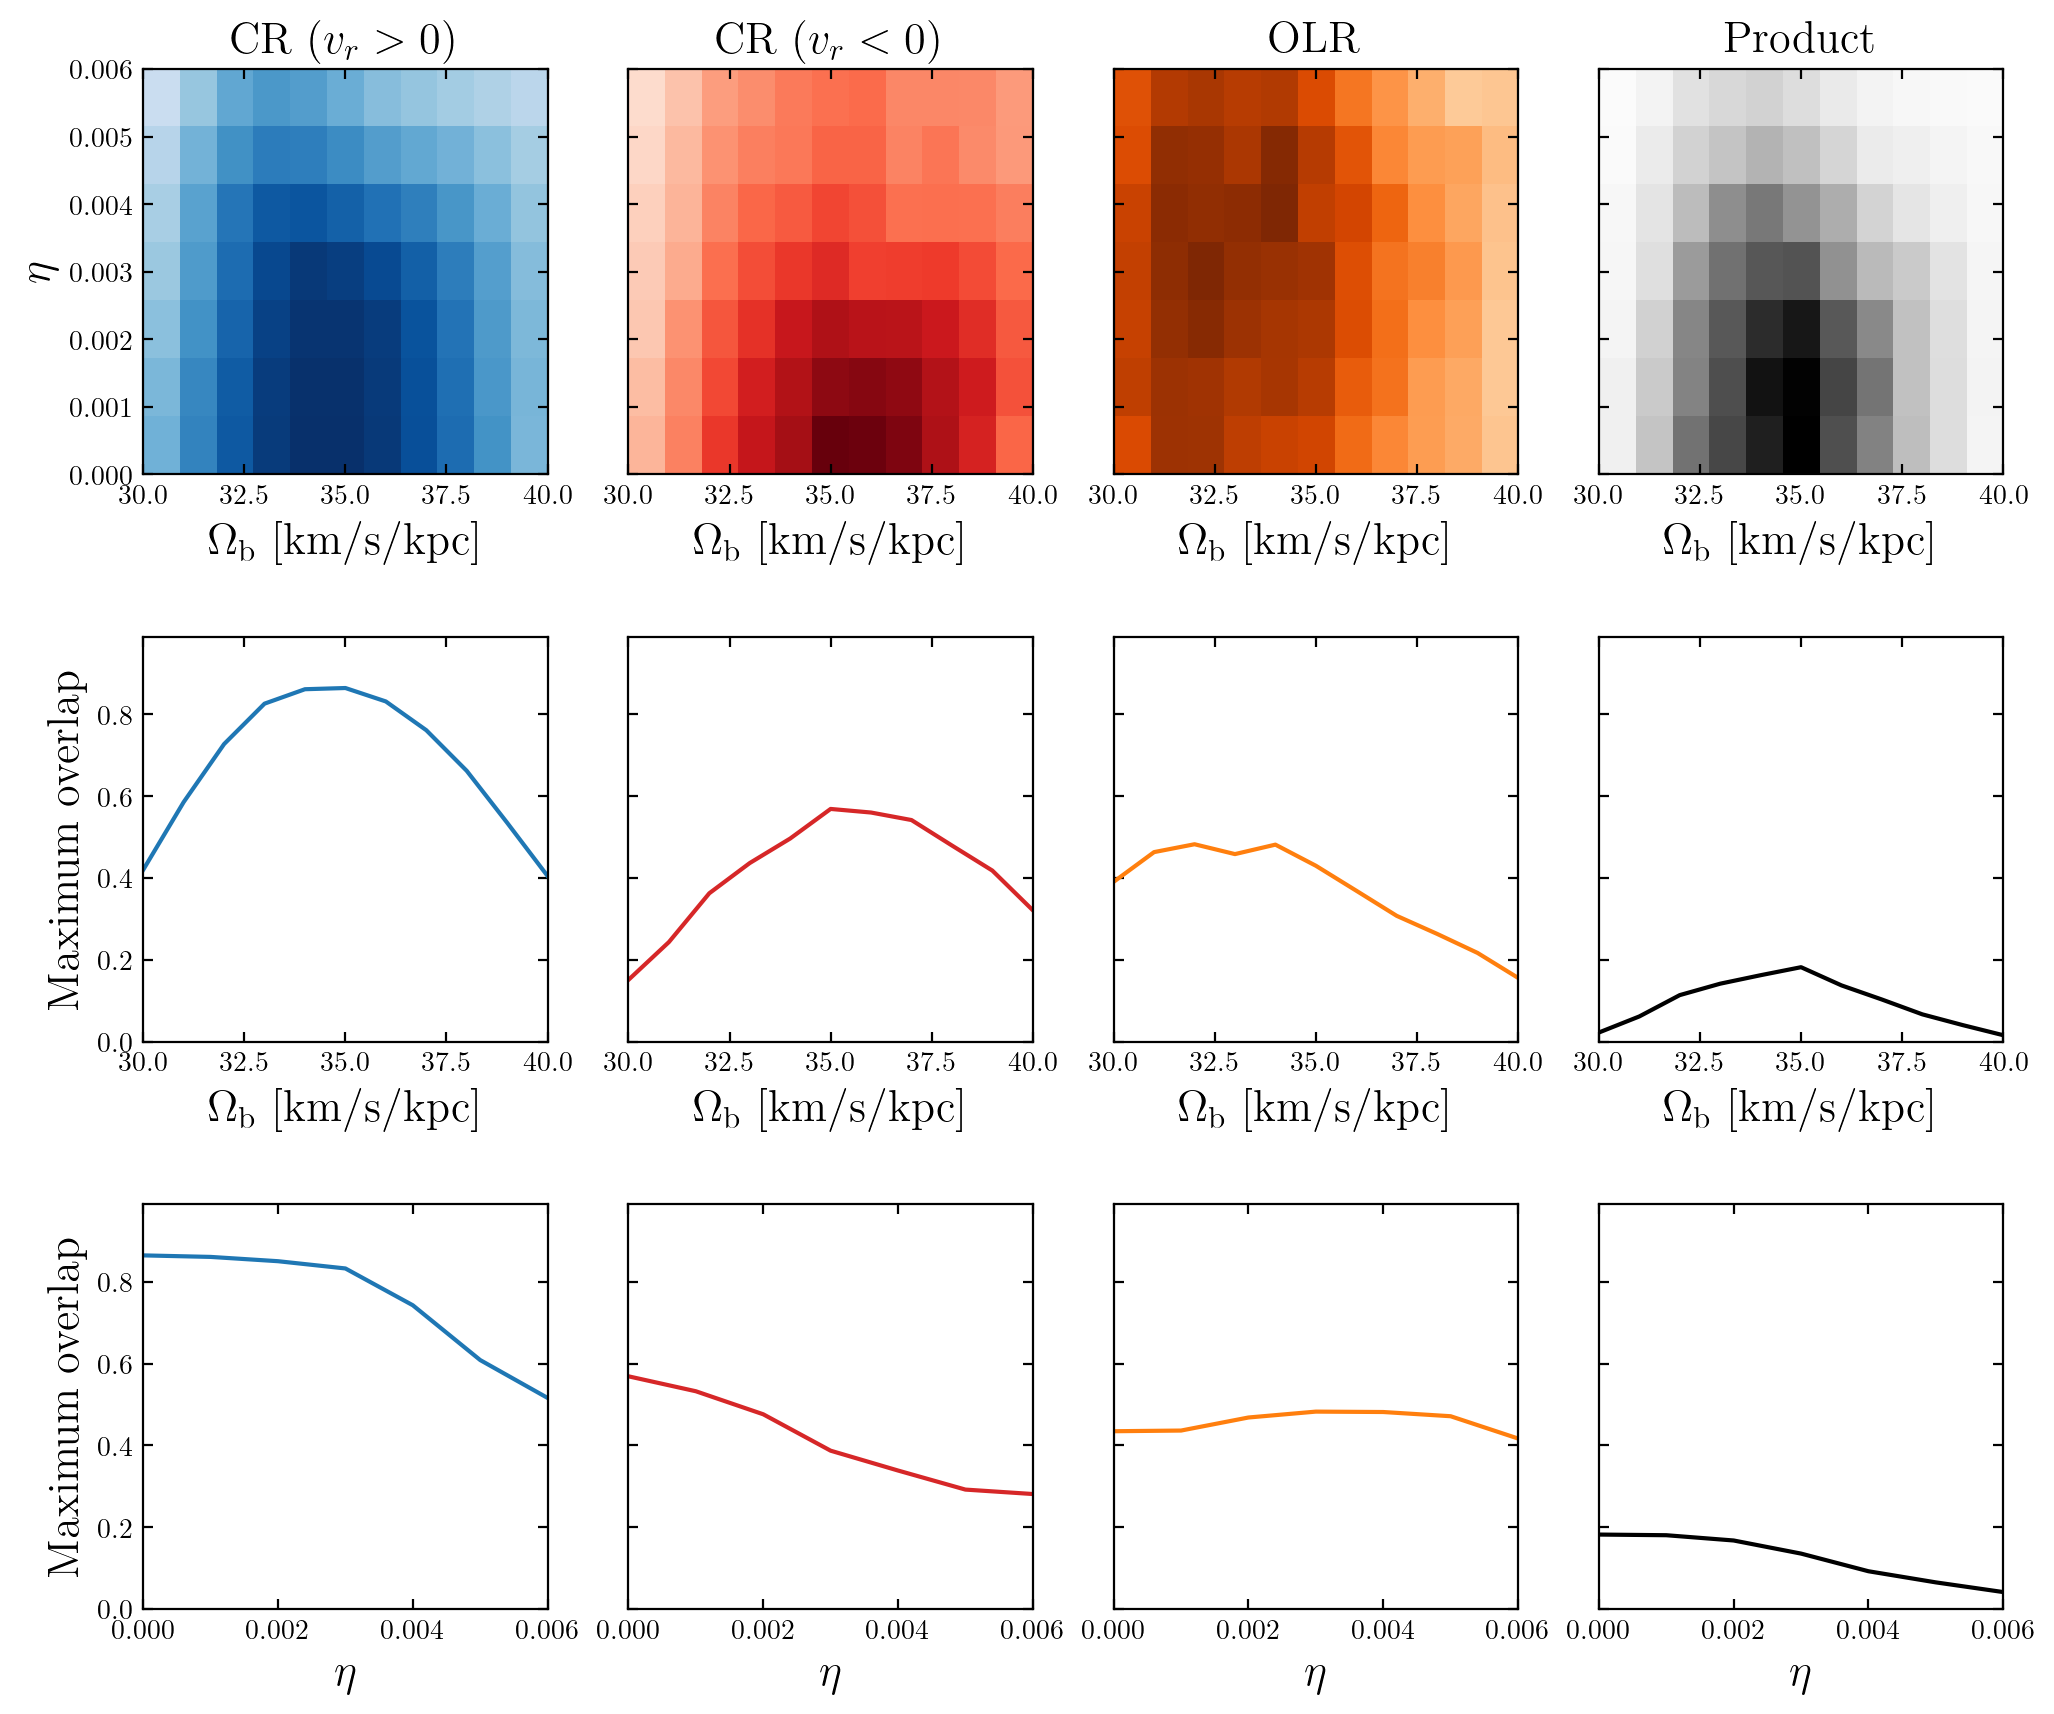

In [855]:
'''Plot overlap vs model parameters'''

# plt.plot(Omega_b_array, log_likelihood_corot_array)
# plt.plot(Omega_b_array, log_likelihood_OLR_array)
# plt.plot(Omega_b_array, log_likelihood_array)

fig, axs = plt.subplots(3, overlap_array.shape[-1]+1, figsize=(12, 10), sharex='row', sharey='row', dpi=200)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

product = np.prod(overlap_array, axis=-1)



colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:gray']
cmaps = ['Blues', 'Reds', 'Oranges', 'Greys']
# linestyles = ['--', ':', '-', '-']
labels = ['CR ($v_r>0$)', 'CR ($v_r<0$)', 'OLR', 'Product']

for k in range(overlap_array.shape[-1]):
    # norm = np.exp(log_likelihood_array[:,:,k]).sum()
    axs[0,k].imshow(overlap_array[:,:,k].T, extent=[Omega_b_array[0], Omega_b_array[-1], eta_array[0], eta_array[-1]], cmap=cmaps[k], aspect='auto', origin='lower', vmin=0, vmax=np.max(overlap_array[:,:,k]))
    axs[1,k].plot(Omega_b_array, np.max(overlap_array[:,:,k], axis=1), c=colors[k], label=labels[k])
    axs[2,k].plot(eta_array, np.max(overlap_array[:,:,k], axis=0), c=colors[k], label=labels[k])

for k in range(overlap_array.shape[-1]+1): 
    axs[0,k].set_xlabel('$\Omega_\mathrm{b}$ [km/s/kpc]', fontsize=16)
    axs[1,k].set_xlabel('$\Omega_\mathrm{b}$ [km/s/kpc]', fontsize=16)
    axs[2,k].set_xlabel('$\eta$', fontsize=16)
    axs[0,k].set_title(labels[k], fontsize=16)

axs[0,0].set_ylabel('$\eta$', fontsize=16)
axs[1,0].set_ylabel('Maximum overlap', fontsize=16)
axs[2,0].set_ylabel('Maximum overlap', fontsize=16)

axs[0,-1].imshow(product.T, extent=[Omega_b_array[0], Omega_b_array[-1], eta_array[0], eta_array[-1]], cmap=cmaps[-1], aspect='auto', origin='lower', vmin=0, vmax=np.max(product))
axs[1,-1].plot(Omega_b_array, product[:,0], c='k', label=labels[-1])
axs[2,-1].plot(eta_array, product[5,:], c='k', label=labels[-1])


# axs[1].legend(ncols=2)

axs[0,0].set_xlim(min(Omega_b_array), max(Omega_b_array))
axs[1,0].set_xlim(min(Omega_b_array),max(Omega_b_array))
axs[1,0].set_ylim(0,0.99)
axs[2,0].set_xlim(min(eta_array),max(eta_array))
axs[2,0].set_ylim(0,0.99)

for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')



In [402]:
'''Test with individual orbits'''

vR_target = -150 #-150
vphi_target = 50 #70

index = np.argmin((vR_grid_flat-vR_target)**2 + (vphi_grid_flat-vphi_target)**2)

plt.plot(orbits[:,index,0], orbits[:,index,1])
plt.show()
plt.close()


af = agama.ActionFinder(pot_axi)
act, ang, freq = af(orbits[:,index], angles=True)

print(find_res(orbits[:,index:index+1], freq, pot_axi, Omega_b_0, 0, 2))

m = 2
l = 0

theta_s = np.unwrap(m*ang[:,2] + l*ang[:,0])#np.unwrap(m*ang[:,2] + l*ang[:,0])

theta_s_rel = theta_s - theta_s[0]

theta_s_rel_wrap = (theta_s_rel + np.pi) % (2*np.pi) - np.pi

print(np.where((np.sign(theta_s_rel_wrap[:-1])*np.sign(theta_s_rel_wrap[1:]) < 0) * (abs(theta_s_rel_wrap[1:] - theta_s_rel_wrap[:-1]) < np.pi))[0])

zero_index = np.where((np.sign(theta_s_rel_wrap[:-1])*np.sign(theta_s_rel_wrap[1:]) < 0) * (abs(theta_s_rel_wrap[1:] - theta_s_rel_wrap[:-1]) < np.pi))[0][0]

plt.plot(theta_s_rel[:])
plt.plot(theta_s_rel_wrap[:])

plt.ylim(-5,5)

plt.axhline(np.pi)
plt.axhline(-np.pi)

theta_s_range = np.max(theta_s_rel_wrap[:zero_index]) - np.min(theta_s_rel_wrap[:zero_index])

res_flag = theta_s_range/(2*np.pi) < 0.9

print(theta_s_range/(2*np.pi))

print(np.max(theta_s[:zero_index]))



# Delta_theta_s = theta_s_wrap - theta_s_wrap[0]

theta_s_mean = np.mean(theta_s)
theta_s_minus_mean = (theta_s - theta_s_mean + np.pi)%(2*np.pi) - np.pi

print(find_res(orbits[:,index:index+1], freq, pot_axi, Omega_b_0, 0, 2))

# print(corot_flag_array[])


NameError: name 'orbits' is not defined

[-107.3398482   305.52281064   73.84794446 ...  135.15067568  -94.48976165
   42.73140542]


/home/adam/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: divide by zero encountered in divide
  self._weights /= sum(self._weights)
/home/adam/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_kde.py:493: RuntimeWarning: divide by zero encountered in power
  return power(self.neff, -1./(self.d+4))


ValueError: aweights cannot be negative

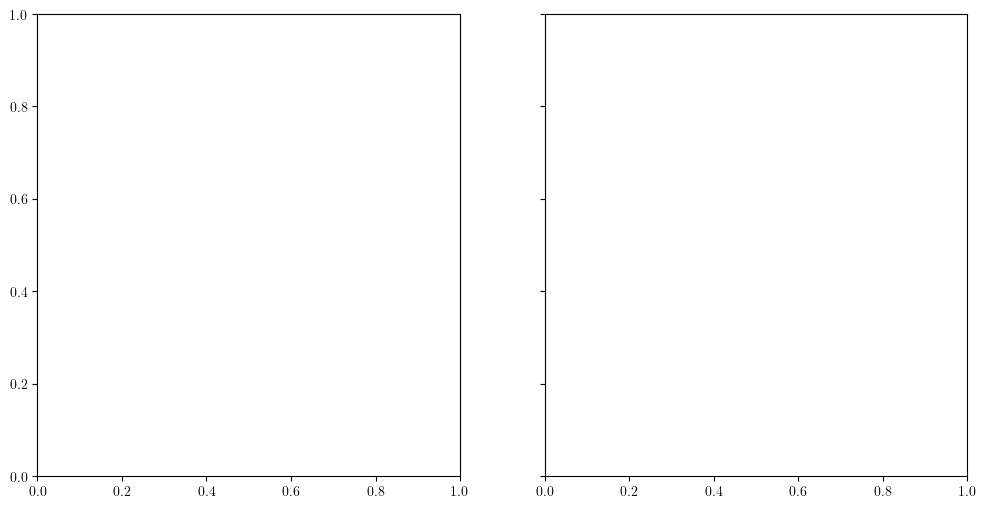

In [134]:
'''Plot antisymmetric distribution and find peaks'''

from scipy.ndimage import gaussian_filter, maximum_filter
from skimage.feature import peak_local_max
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

cut = (MH > -10)*(MH < -1)*(dist<1)#*(eta_data<0.98)#*(logg<3)

bins = np.linspace(-350, 350, 101)

hist, _, _ = np.histogram2d(vR_data[cut], vphi_data[cut], bins=bins)

# ax.imshow(hist.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='none', origin='lower', norm=mcolors.LogNorm(vmax=100), cmap='inferno')

bincentres = 0.5*(bins[1:]+bins[:-1])
# bincentres = 0.5*(V_bins[1:]+V_bins[:-1])
hist_smooth = gaussian_filter(hist, 1.5)

hist_antisym = hist - np.flip(hist, axis=0)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
hist_antisym_smooth = hist_smooth - np.flip(hist_smooth, axis=0)


# Locate peaks in antisymmetric distribution
func_interp = RegularGridInterpolator((bincentres, bincentres), hist_antisym_smooth, method='cubic')

grid = np.linspace(-345, 345, 201)

X, Y = np.meshgrid(grid, grid)

hist_interp = func_interp((X, Y))

peak_index = peak_local_max(hist_interp.T, threshold_rel=0.04, min_distance=10)
peaks = np.array([grid[peak_index[:,0]], grid[peak_index[:,1]]]).T

print(peaks)
# hist_antisym = gaussian_filter(hist_antisym, 0.5)

# ax.imshow(hist_antisym.T, extent=(bins[0],bins[-1],bins[0],bins[-1]), interpolation='none', origin='lower', cmap='gray_r', norm=mcolors.LogNorm())#, vmax=1)

axs[0].contourf(bincentres, bincentres, hist_smooth.T, levels=np.logspace(0, 3, 40), cmap='Greys', norm=mcolors.LogNorm())
axs[0].contour(bincentres, bincentres, hist_smooth.T, levels=np.logspace(0, 3, 40), colors='k', linewidths=0.8)

axs[1].contourf(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.1, 3, 40), cmap='Greys', norm=mcolors.LogNorm())
axs[1].contour(bincentres, bincentres, hist_antisym_smooth.T, levels=np.logspace(0.1, 3, 40), colors='k', linewidths=0.8)

axs[0].scatter(peaks[:,0], peaks[:,1], marker='x', c='tab:red')
axs[1].scatter(peaks[:,0], peaks[:,1], marker='x', c='tab:red')

for ax in axs.flat:
    ax.set_xlabel('$v_R$ [km/s]', fontsize=16)
    ax.set_ylabel('$v_\phi$ [km/s]', fontsize=16)

    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')


axs[0].set_title('$[M/H]<-1$, distance $<1$ kpc', fontsize=16)
axs[1].set_title('$v_R$ asymmetric excess', fontsize=16)
# plt.xlim(-350, -200)
# plt.ylim(-100, 100)

plt.show()
plt.close()

del hist, hist_antisym, hist_antisym_smooth, cut

[0. 0. 0. ... 0. 0. 0.]


/tmp/ipykernel_6102/2496247163.py:21: RuntimeWarning: divide by zero encountered in log
  log_likelihood = hist * cut_nores * np.log(hist_sym_norm)
/tmp/ipykernel_6102/2496247163.py:21: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = hist * cut_nores * np.log(hist_sym_norm)


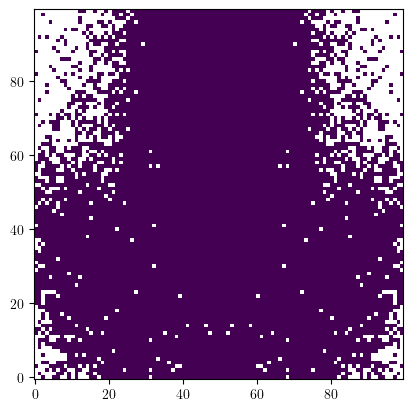

In [111]:
'''Find region of parameter space for which antisymmetric peaks are in resonances'''

vR_grid_flat = peaks[1:,0]
vphi_grid_flat = peaks[1:,1]
N_grid = len(peaks[1:])

bar_angle = 30 * np.pi/180
R_sun = 8.2

int_time = 4
trajsize = 1001

# Array of times
ts = np.linspace(0, int_time, trajsize)

Omega_b_grid = np.linspace(28, 40, 13)
eta_grid = np.linspace(0., 0.01, 11)

corot_flag_array = np.zeros((len(Omega_b_grid), len(eta_grid), len(vR_grid_flat)))
OLR_flag_array = np.zeros((len(Omega_b_grid), len(eta_grid), len(vR_grid_flat)))
one_to_one_flag_array = np.zeros((len(Omega_b_grid), len(eta_grid), len(vR_grid_flat)))
ret_OLR_flag_array = np.zeros((len(Omega_b_grid), len(eta_grid), len(vR_grid_flat)))

for i in range(len(Omega_b_grid)):
    for j in range(len(eta_grid)):
        
        # Calculate angle of slowing bar
        Omega_b_0 = Omega_b_grid[i]
        eta = eta_grid[j]

        if eta==0:
            phi_b = Omega_b_0 * ts
        
        else:
            phi_b = 1/eta * np.log(1 + eta*Omega_b_0*ts)

        # result = solve_ivp(calc_Omega_b, t_span=(ts[0], ts[-1]), y0=[0], t_eval=ts, args=(Omega_b_0, eta))
        # ts = result.t
        # phi_b_test = result.y[0]

        # Calculate rotation matrix
        rot_mat = np.zeros((len(ts), 6, 6))
        rot_mat[:,0:3,0:3] = np.array([[np.cos(phi_b), np.sin(phi_b), 0*ts], [-np.sin(phi_b), np.cos(phi_b), 0*ts], [0*ts, 0*ts, np.ones(len(ts))]]).transpose(2,0,1)
        rot_mat[:,3:6,3:6] = np.array([[np.cos(phi_b), np.sin(phi_b), 0*ts], [-np.sin(phi_b), np.cos(phi_b), 0*ts], [0*ts, 0*ts, np.ones(len(ts))]]).transpose(2,0,1)

        # Slowing barred potential

        # If integrating back in time, flip time and bar angle arrays for potential creation
        if int_time<0:
            ts_pot = np.flip(ts)
            phi_b_pot = np.flip(phi_b)
        else:
            ts_pot = np.copy(ts)
            phi_b_pot = np.copy(phi_b)

        # pot_slow = agama.Potential(file=agama_pot_path+'Portail17.ini', rotation=np.array([ts_pot, phi_b_pot]).T)
        pot_slow = agama.Potential(file=agama_pot_path+'MWPotentialHunter24_full.ini', rotation=np.array([ts_pot, phi_b_pot]).T)

        
        # Set up initial conditions given bar angle (Move this out of the loop later?)
        phi_sun = 2*np.pi-bar_angle

        X_sun = R_sun * np.cos(phi_sun)
        Y_sun = R_sun * np.sin(phi_sun)

        vX_grid = vR_grid_flat * np.cos(-bar_angle) - vphi_grid_flat * np.sin(-bar_angle)
        vY_grid = vR_grid_flat * np.sin(-bar_angle) + vphi_grid_flat * np.cos(-bar_angle)

        ic = np.array([X_sun*np.ones(N_grid), Y_sun*np.ones(N_grid), np.zeros(N_grid), vX_grid, vY_grid, np.zeros(N_grid)+1e-1]).T

        # Steadily rotating bar
        # orbits, ts = test_part_sim(ic, pot_bar, time=int_time, trajsize=trajsize, Omega=Omega_b)

        # Slowing bar
        orbits, _ = test_part_sim(ic, pot_slow, time=int_time, trajsize=trajsize)

        # Rotate coordinates into frame aligned with the bar
        orbits = np.einsum('lij,lmj->lmi', rot_mat, orbits)

        # First calculate frequencies in axisymmetric potential, to identify orbits near resonances
        af = agama.ActionFinder(pot_axi)
        act, ang, freq = af(orbits[0], angles=True)

        # Identify CR orbits
        corot_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 0, 2)

        # Identify OLR orbits
        OLR_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 1, 2)

        # # Identify 1:1 orbits
        # one_to_one_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 1, 1)

        # # Identify "retrograde OLR" orbits
        # ret_OLR_flag_array[i,j] = find_res(orbits, freq, pot_axi, Omega_b_0, 3, 2)

        del orbits
        print('Percentage completion = '+str(np.around(100*(i*len(eta_grid)+j)/(len(Omega_b_grid)*len(eta_grid)),2))+'%')


3 orbits complete (76.92 orbits/s)
Percentage completion = 0.0%
3 orbits complete (73.17 orbits/s)
Percentage completion = 0.7%
3 orbits complete (73.17 orbits/s)
Percentage completion = 1.4%
3 orbits complete (66.67 orbits/s)
Percentage completion = 2.1%
3 orbits complete (68.18 orbits/s)
Percentage completion = 2.8%
3 orbits complete (56.6 orbits/s)
Percentage completion = 3.5%
3 orbits complete (49.18 orbits/s)
Percentage completion = 4.2%
3 orbits complete (56.6 orbits/s)
Percentage completion = 4.9%
3 orbits complete (68.18 orbits/s)
Percentage completion = 5.59%
3 orbits complete (43.48 orbits/s)
Percentage completion = 6.29%
3 orbits complete (58.82 orbits/s)
Percentage completion = 6.99%
3 orbits complete (69.77 orbits/s)
Percentage completion = 9.09%
3 orbits complete (44.12 orbits/s)
Percentage completion = 9.79%
3 orbits complete (65.22 orbits/s)
Percentage completion = 10.49%
3 orbits complete (73.17 orbits/s)
Percentage completion = 11.19%
3 orbits complete (68.18 orbits/s

[[ -20.7   238.05]
 [  82.8   169.05]
 [-141.45   55.2 ]
 [-286.35   34.5 ]]


Text(0, 0.5, '$\\eta$')

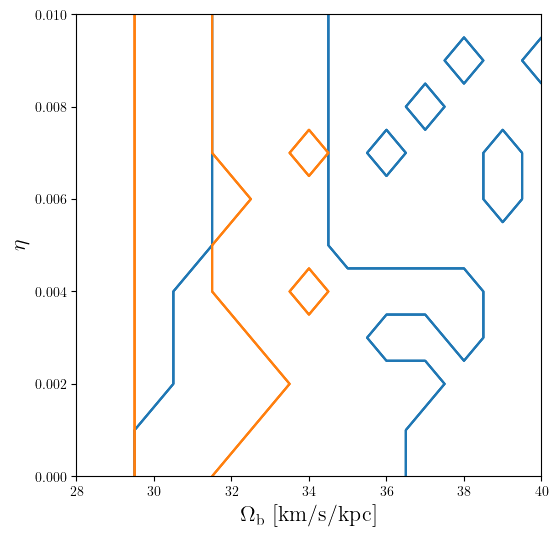

In [114]:
'''Plot results'''

fig, ax = plt.subplots(figsize=(6,6))

print(peaks)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i in range(corot_flag_array.shape[-1]):
    # ax.contour(Omega_b_grid, eta_grid, corot_flag_array[:,:,0].T, levels=[0.5], colors='tab:blue')
    # ax.contourf(Omega_b_grid, eta_grid, corot_flag_array[:,:,0].T, levels=[0.5,1], cmap='Blues')

    ax.contour(Omega_b_grid, eta_grid, corot_flag_array[:,:,1].T, levels=[0.5], colors='tab:blue')
    # ax.contourf(Omega_b_grid, eta_grid, corot_flag_array[:,:,1].T, levels=[0.5,1], cmap='Blues', alpha=0.2)

for i in range(OLR_flag_array.shape[-1]):
    ax.contour(Omega_b_grid, eta_grid, OLR_flag_array[:,:,2].T, levels=[0.5], colors='tab:orange')
    # ax.contourf(Omega_b_grid, eta_grid, OLR_flag_array[:,:,2].T, levels=[0.5,1], cmap='Oranges', alpha=0.2)


ax.set_xlabel('$\Omega_\mathrm{b}$ [km/s/kpc]', fontsize=16)
ax.set_ylabel('$\eta$', fontsize=16)


# for i in range(one_to_one_flag_array.shape[-1]):
#     ax.contour(Omega_b_grid, eta_grid, one_to_one_flag_array[:,:,i].T, levels=[0.5], colors='tab:green')

# for i in range(corot_flag_array.shape[-1]):
#     ax.contour(Omega_b_grid, eta_grid, corot_flag_array[:,:,i].T, levels=[0.5], colors='tab:blue')

# for i in range(OLR_flag_array.shape[-1]):
#     ax.imshow(OLR_flag_array[:,:,1].T, extent=[Omega_b_grid[0], Omega_b_grid[-1], eta_grid[0], eta_grid[-1]], cmap='Reds', aspect='auto', origin='lower')

# for i in range(one_to_one_flag_array.shape[-1]):
#     ax.imshow(one_to_one_flag_array[:,:,1].T, extent=[Omega_b_grid[0], Omega_b_grid[-1], eta_grid[0], eta_grid[-1]], cmap='Reds', aspect='auto', origin='lower')
